#Image Splicing Forgery Detection with RRU-Net


---


@Authors:
*   Alessandro Lambertini
*   Denise Landini

##Import libraries

In [6]:
import os
import time
import random
import numpy as np

from imageio import imread

from skimage.transform import resize
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Function
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
from IPython.display import HTML, display

def progress(value, max=100):
  return HTML("""
    <progress
      value='{value}'
      max='{max}',
      style='width: 50%'
    >
        {value}
    </progress>
  """.format(value=value, max=max))

In [7]:
from google.colab import drive
drive.mount('/content/drive')

# global variables to dataset
dir = 'drive/MyDrive/Colab Notebooks/V&P/Final Project/'

Mounted at /content/drive


##RRU-Net

###blocks of RRU-NET

In [8]:
class RRU_conv(nn.Module):
  def __init__(self, nin, nout):
    super(RRU_conv, self).__init__()

    self.rru_c = torch.nn.Sequential(
      # first convolution
      torch.nn.Conv2d(nin, nout, 3, padding=2, dilation=2),
      torch.nn.GroupNorm(32, nout),
      torch.nn.ReLU(inplace=True),

      # second convolution
      torch.nn.Conv2d(nout, nout, 3, padding=2, dilation=2),
      torch.nn.GroupNorm(32, nout),
    )

  def forward(self, x):
    x = self.rru_c(x)
    return x

class RRU_Block_E(nn.Module):
  def __init__(self, nin, nout):
    super(RRU_Block_E, self).__init__()

    self.act = nn.ReLU(inplace=True)

    self.rru_c1 = RRU_conv(nin, nout)

    # Residual Propagation
    self.Residual_Propagation_c = torch.nn.Conv2d(nin, nout, kernel_size=1, bias=False)
    self.Residual_Propagation_n = torch.nn.GroupNorm(32, nout)

    # Residual Feedback
    self.Residual_Feedback = torch.nn.Conv2d(nout, nin, kernel_size=1, bias=False)

  def forward(self, x):
    # Residual Propagation
    rru_c1 = self.rru_c1(x)
    rp = self.Residual_Propagation_n(self.Residual_Propagation_c(x))

    rp = self.act(rru_c1 + rp)

    # Residual Feedback
    rf = self.Residual_Feedback(rp)
    x = torch.mul(1 + torch.sigmoid(rf), x)

    # std path
    rru_c2 = self.rru_c1(x)
    rp = self.Residual_Propagation_n(self.Residual_Propagation_c(x))

    out = self.act(rru_c2 + rp)
    return out


class RRU_block_D(nn.Module):
  def __init__(self, nin, nout):
    super(RRU_block_D, self).__init__()

    self.act = torch.nn.ReLU(inplace=True)
    
    self.cT1 = torch.nn.ConvTranspose2d(nin // 2, nin // 2, 2, stride=2)
    self.n1 = torch.nn.GroupNorm(32, nin // 2)

    self.rru_c1 = RRU_conv(nin, nout)
      
    # Residual Propagation
    self.Residual_Propagation_c = torch.nn.Conv2d(nin, nout, kernel_size=1, bias=False)
    self.Residual_Propagation_n = torch.nn.GroupNorm(32, nout)

    # Residual Feedback
    self.Residual_Feedback = torch.nn.Conv2d(nout, nin, kernel_size=1, bias=False)

  def forward(self, x1, x2):

    x1 = self.n1(self.cT1(x1))
    x1 = F.pad(x1, (x2.size()[3] - x1.size()[3], 0,
                    x2.size()[2] - x1.size()[2], 0))
    
    x = self.act(torch.cat([x2, x1], dim=1))

    # Residual Propagation
    rru_c1 = self.rru_c1(x)
    rp = self.Residual_Propagation_n(self.Residual_Propagation_c(x))

    rp = self.act(rp + rru_c1)

    # Residual Feedback
    rf = self.Residual_Feedback(rp)
    x = torch.mul(1 + torch.sigmoid(rf), x)

    # std path
    rru_c2 = self.rru_c1(x)
    rp = self.Residual_Propagation_n(self.Residual_Propagation_c(x))

    out = self.act(rru_c2 + rp)
    return out

###evalDice

In [9]:
def evalDice(input, target):
  summ = torch.FloatTensor(1).cuda().zero_()
  for i, t in enumerate(zip(input, target)):
    summ = summ + DiceCoeff().forward(t[0], t[1])
  return summ / (i + 1)

class DiceCoeff(Function):
  def forward(self, input, target):
    self.save_for_backward(input, target)
    self.inter = torch.dot(input.view(-1), target.view(-1))
    self.union = torch.sum(input) + torch.sum(target) + 0.0001
    return (2 * self.inter.float() + 0.0001) / self.union.float()

    def backward(self, grad_output):
      input, target = self.saved_variables
      grad_input = None
      if self.needs_input_grad[0]:
        grad_input = grad_output * 2 * (target * self.union + self.inter) \
                      / self.union * self.union
      return grad_input, None

###Complete architecture of RRU-Net

In [10]:
class RRU_NET(nn.Module):
  def __init__(self, nin=3, nout=1, debug=False):
    super(RRU_NET, self).__init__()

    self.debug = debug

    # Encoder
    # first layer
    self.e1_1 = RRU_Block_E(nin, 32)
    self.e1_2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # second layer
    self.e2_1 = RRU_Block_E(32, 64)
    self.e2_2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # third layer
    self.e3_1 = RRU_Block_E(64, 128)
    self.e3_2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # fourth layer
    self.e4_1 = RRU_Block_E(128, 256)
    self.e4_2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # fifth layer
    self.encoder_output = RRU_Block_E(256, 256)
    # END Encoder

    # Decoder
    # first layer
    self.d1_1 = RRU_block_D(512, 128)

    # second layer
    self.d2_1 = RRU_block_D(256, 64)

    # third layer
    self.d3_1 = RRU_block_D(128, 32)

    # fourth layer
    self.d4_1 = RRU_block_D(64, 32)

    # output
    self.decoder_output = nn.Conv2d(32, nout, 1)

  def forward(self, x):
    if self.debug:
      print("x.shape : ", x.shape)

    # Encoder
    # first layer
    e1_1 = self.e1_1(x)
    if self.debug:
      print("e1_1.shape : ", e1_1.shape)
    e1_2 = self.e1_2(e1_1)
    if self.debug:
      print("e1_2.shape : ", e1_2.shape)
    
    # second layer
    e2_1 = self.e2_1(e1_2)
    if self.debug:
      print("e2_1.shape : ", e2_1.shape)
    e2_2 = self.e2_2(e2_1)
    if self.debug:
      print("e2_2.shape : ", e2_2.shape)

    # third layer
    e3_1 = self.e3_1(e2_2)
    if self.debug:
      print("e3_1.shape : ", e3_1.shape)
    e3_2 = self.e3_2(e3_1)
    if self.debug:
      print("e3_2.shape : ", e3_2.shape)

    # fourth layer
    e4_1 = self.e4_1(e3_2)
    if self.debug:
      print("e4_1.shape : ", e4_1.shape)
    e4_2 = self.e4_2(e4_1)
    if self.debug:
      print("e4_2.shape : ", e4_2.shape)

    # fifth layer
    encoder_output = self.encoder_output(e4_2)
    if self.debug:
      print("encoder_output.shape : ", encoder_output.shape)
    # END Encoder

    decoder_input = encoder_output

    # Decoder
    # first layer
    d1_1 = self.d1_1(decoder_input, e4_1)
    if self.debug:
      print("d1_1.shape : ", d1_1.shape)

    # second layer
    d2_1 = self.d2_1(d1_1, e3_1)
    if self.debug:
      print("d2_1.shape : ", d2_1.shape)

    # third layer
    d3_1 = self.d3_1(d2_1, e2_1)
    if self.debug:
      print("d3_1.shape : ", d3_1.shape)

    # fourth layer
    d4_1 = self.d4_1(d3_1, e1_1)
    if self.debug:
      print("d4_1.shape : ", d4_1.shape)
    
    # output
    decoder_output = self.decoder_output(d4_1)
    if self.debug:
      print("decoder_output.shape : ", decoder_output.shape)
    
    return decoder_output

##Preprocessing of the data

###Load and split data

In [6]:
input_shape = (384, 256)
input_shape_w, input_shape_h = 384, 256
images_i = []
images_o = []

dir_img = dir+'dataset/label_in_wild/images/'
dir_mask = dir+'dataset/label_in_wild/masks/'

torch.cuda.empty_cache()

imgs_load = 184
i_path = sorted(os.listdir(dir_img))[0:imgs_load]
o_path = sorted(os.listdir(dir_mask))[0:imgs_load]

out = display(progress(0, len(i_path)-1), display_id=True)
print("Image input: %s" %str(input_shape))
print("Images in the dataset: %d" %(len(os.listdir(dir_img))))
print("Images loaded: %d" %(imgs_load))

for i in range(len(i_path)):
  appimgI = imread(dir_img+i_path[i])
  appimgO = imread(dir_mask+o_path[i])

  images_i.append(resize(appimgI, (input_shape_w, input_shape_h, 3)))
  images_o.append(resize(appimgO, (input_shape_w, input_shape_h)))

  del appimgI
  del appimgO
  out.update(progress(i, len(i_path)-1))

Image input: (384, 256)
Images in the dataset: 184
Images loaded: 184


In [7]:
splitting = 0.3
x_train, x_test, y_train, y_test = train_test_split(images_i, images_o, test_size=splitting, shuffle=False, random_state=2)

x_train = np.array([x_train[i] for i in range(len(x_train)) ]).astype(np.float32)
y_train = np.array([y_train[i] for i in range(len(y_train)) ]).astype(np.float32)
x_test = np.array([x_test[i] for i in range(len(x_test)) ]).astype(np.float32)
y_test = np.array([y_test[i] for i in range(len(y_test)) ]).astype(np.float32)

x_train = np.transpose(x_train, axes=[0, 3, 1, 2])
x_test = np.transpose(x_test, axes=[0, 3, 1, 2])

x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()

x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

print("dataset splitted in {}% train set and {}% test set".format((1-splitting)*100, (splitting)*100) )
print("number of train images: %d" %(x_train.shape[0]))
print("number of test images: %d" %(x_test.shape[0]))

print("x_train.shape : ", x_train.shape)
print("y_train.shape : ", y_train.shape)
print("x_test.shape : ", x_test.shape)
print("y_test.shape : ", y_test.shape)

dataset splitted in 70.0% train set and 30.0% test set
number of train images: 128
number of test images: 56
x_train.shape :  torch.Size([128, 3, 384, 256])
y_train.shape :  torch.Size([128, 384, 256])
x_test.shape :  torch.Size([56, 3, 384, 256])
y_test.shape :  torch.Size([56, 384, 256])


###Generate a random image input and the respective output

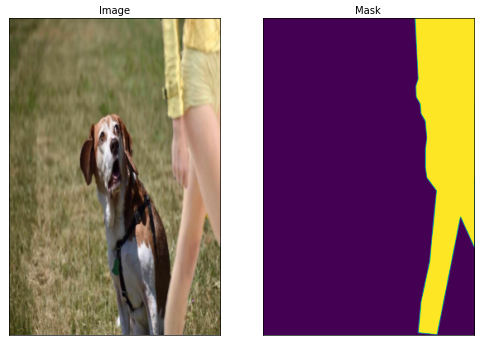

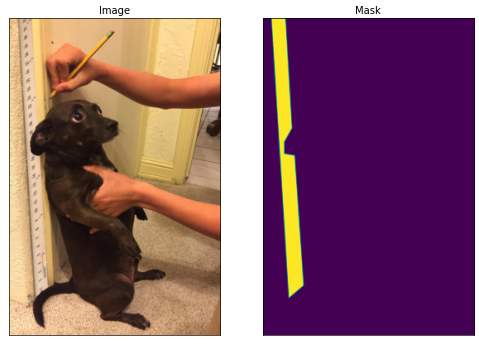

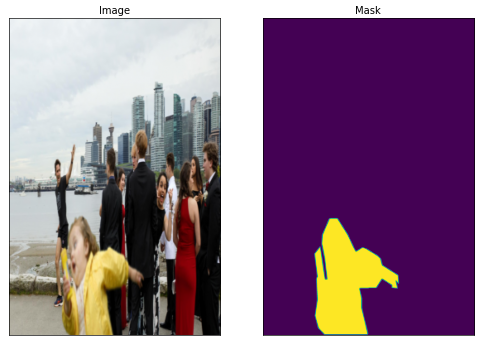

In [8]:
N = 3

for _ in range(N):
  i = random.randint(0, len(images_i)-1)
  f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 15), dpi=60)
  plt.setp(ax, xticks=[], yticks=[])
  ax[0].title.set_text("Image")
  ax[0].imshow(images_i[i]) # images_i
  ax[1].title.set_text("Mask")
  ax[1].imshow(images_o[i]) # images_o

##Train the model

In [11]:
dir_img = dir+'dataset/label_in_wild/images/'
dir_mask = dir+'dataset/label_in_wild/masks/'

net = RRU_NET(nin=3, nout=1).cuda()

nb_param = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("Net Structure: \n", net)

print("\nRRU Net Build")
print("Model Info --------------------")
print("Number of trainable parameters : "+str(nb_param))

Net Structure: 
 RRU_NET(
  (e1_1): RRU_Block_E(
    (act): ReLU(inplace=True)
    (rru_c1): RRU_conv(
      (rru_c): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): GroupNorm(32, 32, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (4): GroupNorm(32, 32, eps=1e-05, affine=True)
      )
    )
    (Residual_Propagation_c): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (Residual_Propagation_n): GroupNorm(32, 32, eps=1e-05, affine=True)
    (Residual_Feedback): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (e1_2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (e2_1): RRU_Block_E(
    (act): ReLU(inplace=True)
    (rru_c1): RRU_conv(
      (rru_c): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), di

Epoch: 1/50.
TRAINING


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


TESTING


dice_train: 0.2857, loss_train: 0.5078
dice_test: 0.0709, loss_test: 15.7812
time 16.23  s

Epoch: 2/50.
TRAINING


TESTING


dice_train: 0.2806, loss_train: 0.4797
dice_test: 0.0536, loss_test: 15.5181
time 16.07  s

Epoch: 3/50.
TRAINING


TESTING


dice_train: 0.2878, loss_train: 0.4659
dice_test: 0.0615, loss_test: 15.9565
time 15.84  s

Epoch: 4/50.
TRAINING


TESTING


dice_train: 0.2902, loss_train: 0.4688
dice_test: 0.0355, loss_test: 15.5986
time 15.63  s

Epoch: 5/50.
TRAINING


TESTING


dice_train: 0.2975, loss_train: 0.4595
dice_test: 0.0201, loss_test: 15.4204
time 15.64  s

Epoch: 6/50.
TRAINING


TESTING


dice_train: 0.2989, loss_train: 0.4555
dice_test: 0.0549, loss_test: 15.5295
time 15.74  s

Epoch: 7/50.
TRAINING


TESTING


dice_train: 0.2970, loss_train: 0.4543
dice_test: 0.0243, loss_test: 15.3105
time 15.85  s

Epoch: 8/50.
TRAINING


TESTING


dice_train: 0.2984, loss_train: 0.4527
dice_test: 0.0279, loss_test: 15.4261
time 15.85  s

Epoch: 9/50.
TRAINING


TESTING


dice_train: 0.3013, loss_train: 0.4535
dice_test: 0.0110, loss_test: 15.2515
time 15.79  s

Epoch: 10/50.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4519
dice_test: 0.0230, loss_test: 15.2814
time 15.70  s

Epoch: 11/50.
TRAINING


TESTING


dice_train: 0.3018, loss_train: 0.4527
dice_test: 0.0090, loss_test: 15.1672
time 15.72  s

Epoch: 12/50.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4514
dice_test: 0.0134, loss_test: 15.2171
time 15.74  s

Epoch: 13/50.
TRAINING


TESTING


dice_train: 0.3048, loss_train: 0.4503
dice_test: 0.0071, loss_test: 15.1391
time 15.78  s

Epoch: 14/50.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4521
dice_test: 0.0092, loss_test: 15.1712
time 15.77  s

Epoch: 15/50.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4500
dice_test: 0.0020, loss_test: 15.1448
time 15.75  s

Epoch: 16/50.
TRAINING


TESTING


dice_train: 0.3058, loss_train: 0.4482
dice_test: 0.0051, loss_test: 15.1597
time 15.77  s

Epoch: 17/50.
TRAINING


TESTING


dice_train: 0.3052, loss_train: 0.4477
dice_test: 0.0035, loss_test: 15.1493
time 15.76  s

Epoch: 18/50.
TRAINING


TESTING


dice_train: 0.3057, loss_train: 0.4487
dice_test: 0.0114, loss_test: 15.1894
time 15.76  s

Epoch: 19/50.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4510
dice_test: 0.0089, loss_test: 15.1662
time 15.72  s

Epoch: 20/50.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4479
dice_test: 0.0055, loss_test: 15.1775
time 15.73  s

Epoch: 21/50.
TRAINING


TESTING


dice_train: 0.3059, loss_train: 0.4466
dice_test: 0.0026, loss_test: 15.1515
time 15.76  s

Epoch: 22/50.
TRAINING


TESTING


dice_train: 0.3023, loss_train: 0.4526
dice_test: 0.0024, loss_test: 15.1502
time 15.73  s

Epoch: 23/50.
TRAINING


TESTING


dice_train: 0.2988, loss_train: 0.4514
dice_test: 0.0392, loss_test: 15.3628
time 15.70  s

Epoch: 24/50.
TRAINING


TESTING


dice_train: 0.3034, loss_train: 0.4504
dice_test: 0.0062, loss_test: 15.1380
time 15.71  s

Epoch: 25/50.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4503
dice_test: 0.0006, loss_test: 15.1396
time 15.72  s

Epoch: 26/50.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4485
dice_test: 0.0167, loss_test: 15.2063
time 15.74  s

Epoch: 27/50.
TRAINING


TESTING


dice_train: 0.3044, loss_train: 0.4474
dice_test: 0.0070, loss_test: 15.1589
time 15.72  s

Epoch: 28/50.
TRAINING


TESTING


dice_train: 0.3056, loss_train: 0.4482
dice_test: 0.0245, loss_test: 15.2640
time 15.73  s

Epoch: 29/50.
TRAINING


TESTING


dice_train: 0.3009, loss_train: 0.4480
dice_test: 0.0245, loss_test: 15.2348
time 15.75  s

Epoch: 30/50.
TRAINING


TESTING


dice_train: 0.3045, loss_train: 0.4527
dice_test: 0.0172, loss_test: 15.2046
time 15.73  s

Epoch: 31/50.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4473
dice_test: 0.0234, loss_test: 15.2794
time 15.70  s

Epoch: 32/50.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4477
dice_test: 0.0334, loss_test: 15.2263
time 15.71  s

Epoch: 33/50.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4463
dice_test: 0.0512, loss_test: 15.3659
time 15.69  s

Epoch: 34/50.
TRAINING


TESTING


dice_train: 0.3034, loss_train: 0.4501
dice_test: 0.0010, loss_test: 15.1413
time 15.70  s

Epoch: 35/50.
TRAINING


TESTING


dice_train: 0.3039, loss_train: 0.4509
dice_test: 0.0389, loss_test: 15.3379
time 15.69  s

Epoch: 36/50.
TRAINING


TESTING


dice_train: 0.3051, loss_train: 0.4534
dice_test: 0.0000, loss_test: 15.1575
time 15.70  s

Epoch: 37/50.
TRAINING


TESTING


dice_train: 0.3027, loss_train: 0.4518
dice_test: 0.0105, loss_test: 15.2139
time 15.68  s

Epoch: 38/50.
TRAINING


TESTING


dice_train: 0.3024, loss_train: 0.4504
dice_test: 0.0061, loss_test: 15.1011
time 15.69  s

Epoch: 39/50.
TRAINING


TESTING


dice_train: 0.3054, loss_train: 0.4506
dice_test: 0.0216, loss_test: 15.2512
time 15.67  s

Epoch: 40/50.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4479
dice_test: 0.0098, loss_test: 15.1660
time 15.68  s

Epoch: 41/50.
TRAINING


TESTING


dice_train: 0.3051, loss_train: 0.4510
dice_test: 0.0006, loss_test: 15.1559
time 15.70  s

Epoch: 42/50.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4458
dice_test: 0.0025, loss_test: 15.1592
time 15.70  s

Epoch: 43/50.
TRAINING


TESTING


dice_train: 0.3008, loss_train: 0.4553
dice_test: 0.0012, loss_test: 15.1500
time 15.68  s

Epoch: 44/50.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4480
dice_test: 0.0568, loss_test: 15.6675
time 15.70  s

Epoch: 45/50.
TRAINING


TESTING


dice_train: 0.3058, loss_train: 0.4501
dice_test: 0.0068, loss_test: 15.1619
time 15.68  s

Epoch: 46/50.
TRAINING


TESTING


dice_train: 0.3041, loss_train: 0.4490
dice_test: 0.0081, loss_test: 15.1545
time 15.69  s

Epoch: 47/50.
TRAINING


TESTING


dice_train: 0.3040, loss_train: 0.4493
dice_test: 0.0067, loss_test: 15.1641
time 15.67  s

Epoch: 48/50.
TRAINING


TESTING


dice_train: 0.3059, loss_train: 0.4488
dice_test: 0.0075, loss_test: 15.1276
time 15.69  s

Epoch: 49/50.
TRAINING


TESTING


dice_train: 0.3047, loss_train: 0.4473
dice_test: 0.0070, loss_test: 15.1743
time 15.69  s

Epoch: 50/50.
TRAINING


TESTING


dice_train: 0.3069, loss_train: 0.4456
dice_test: 0.0404, loss_test: 15.4007
time 15.69  s



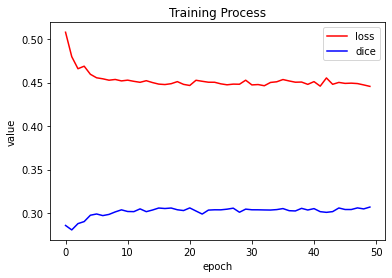

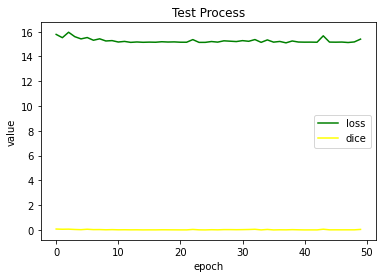

In [9]:
NUM_EPOCHS = 50

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
criterion = nn.BCELoss()

loss_train = []
dice_train = []
loss_test = []
dice_test = []

for epoch in range(NUM_EPOCHS):
  app_loss_train = []
  app_dice_train = []
  app_loss_test = []
  app_dice_test = []

  print('Epoch: {}/{}.'.format(epoch + 1, NUM_EPOCHS))
  print("TRAINING")
  net.train()
  start_epoch = time.time()

  appLoss = 0
  out = display(progress(0, len(x_train)-1), display_id=True)
  start_pat = time.time()
  for i in range(len(x_train)):
    start_batch = time.time()

    output = net(x_train[i].reshape((1, *(x_train[i].shape))))
    output = torch.sigmoid(output)

    loss = criterion(output.view(-1), y_train[i].view(-1))
    app_loss_train.append(loss.cpu().item())
    app_dice_train.append(evalDice(output, y_test).item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    out.update(progress(i, len(x_train)-1))

  print("TESTING")
  out_disp = display(progress(0, len(x_test)-1), display_id=True)
  for i in range(len(x_test)):

    output = net(x_test[i].reshape((1, *(x_train[i].shape))))
    output = (torch.sigmoid(output) > 0.5).float()

    loss = criterion(output[0][0], y_test[i])
    app_loss_test.append(loss.cpu().item())
    app_dice_test.append(evalDice(output, y_test).item())

    print(output.shape, y[i].shape)

    out_disp.update(progress(i, len(x_test)-1))

  
  loss_train.append(sum(app_loss_train)/len(app_loss_train))
  dice_train.append(sum(app_dice_train)/len(app_dice_train))
  loss_test.append(sum(app_loss_test)/len(app_loss_test))
  dice_test.append(sum(app_dice_test)/len(app_dice_test))

  print("dice_train: {:.4f}, loss_train: {:.4f}".format(dice_train[-1], loss_train[-1]))
  print("dice_test: {:.4f}, loss_test: {:.4f}".format(dice_test[-1], loss_test[-1]))
  print("time {:.2f}".format(time.time() - start_pat), " s\n")

fig = plt.figure()
plt.title('Training Process')
plt.xlabel('epoch')
plt.ylabel('value')
l1, = plt.plot(loss_train, c='red')
l2, = plt.plot(dice_train, c='blue')
plt.legend(handles=[l1, l2], labels=['loss', 'dice'], loc='best')

fig = plt.figure()
plt.title('Test Process')
plt.xlabel('epoch')
plt.ylabel('value')
l1, = plt.plot(loss_test, c='green')
l2, = plt.plot(dice_test, c='yellow')
plt.legend(handles=[l1, l2], labels=['loss', 'dice'], loc='best')

Epoch: 1/500.
TRAINING


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


TESTING


dice_train: 0.2774, loss_train: 0.5147
dice_test: 0.0000, loss_test: 15.1578
time 15.91  s

Epoch: 2/500.
TRAINING


TESTING


dice_train: 0.2777, loss_train: 0.4812
dice_test: 0.0013, loss_test: 15.1700
time 16.24  s

Epoch: 3/500.
TRAINING


TESTING


dice_train: 0.2846, loss_train: 0.4769
dice_test: 0.0001, loss_test: 15.1571
time 16.01  s

Epoch: 4/500.
TRAINING


TESTING


dice_train: 0.2824, loss_train: 0.4810
dice_test: 0.0503, loss_test: 15.6137
time 15.75  s

Epoch: 5/500.
TRAINING


TESTING


dice_train: 0.2774, loss_train: 0.4796
dice_test: 0.1284, loss_test: 17.0443
time 15.62  s

Epoch: 6/500.
TRAINING


TESTING


dice_train: 0.2801, loss_train: 0.4799
dice_test: 0.0918, loss_test: 16.1896
time 15.70  s

Epoch: 7/500.
TRAINING


TESTING


dice_train: 0.2791, loss_train: 0.4744
dice_test: 0.1081, loss_test: 16.4611
time 15.87  s

Epoch: 8/500.
TRAINING


TESTING


dice_train: 0.2847, loss_train: 0.4719
dice_test: 0.0376, loss_test: 15.5283
time 15.92  s

Epoch: 9/500.
TRAINING


TESTING


dice_train: 0.2947, loss_train: 0.4645
dice_test: 0.1048, loss_test: 16.1188
time 15.84  s

Epoch: 10/500.
TRAINING


TESTING


dice_train: 0.2899, loss_train: 0.4586
dice_test: 0.0098, loss_test: 15.2322
time 15.78  s

Epoch: 11/500.
TRAINING


TESTING


dice_train: 0.2955, loss_train: 0.4533
dice_test: 0.0190, loss_test: 15.2470
time 15.72  s

Epoch: 12/500.
TRAINING


TESTING


dice_train: 0.2950, loss_train: 0.4542
dice_test: 0.0068, loss_test: 15.1087
time 15.74  s

Epoch: 13/500.
TRAINING


TESTING


dice_train: 0.2999, loss_train: 0.4512
dice_test: 0.0213, loss_test: 15.2724
time 15.77  s

Epoch: 14/500.
TRAINING


TESTING


dice_train: 0.2990, loss_train: 0.4509
dice_test: 0.0032, loss_test: 15.1099
time 15.79  s

Epoch: 15/500.
TRAINING


TESTING


dice_train: 0.3032, loss_train: 0.4494
dice_test: 0.0078, loss_test: 15.1193
time 15.79  s

Epoch: 16/500.
TRAINING


TESTING


dice_train: 0.3024, loss_train: 0.4488
dice_test: 0.0136, loss_test: 15.1902
time 15.77  s

Epoch: 17/500.
TRAINING


TESTING


dice_train: 0.3034, loss_train: 0.4499
dice_test: 0.0011, loss_test: 15.1336
time 15.78  s

Epoch: 18/500.
TRAINING


TESTING


dice_train: 0.3034, loss_train: 0.4475
dice_test: 0.0084, loss_test: 15.1376
time 15.77  s

Epoch: 19/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4478
dice_test: 0.0084, loss_test: 15.1568
time 15.80  s

Epoch: 20/500.
TRAINING


TESTING


dice_train: 0.3033, loss_train: 0.4467
dice_test: 0.0109, loss_test: 15.1547
time 15.78  s

Epoch: 21/500.
TRAINING


TESTING


dice_train: 0.2992, loss_train: 0.4503
dice_test: 0.0026, loss_test: 15.1107
time 15.78  s

Epoch: 22/500.
TRAINING


TESTING


dice_train: 0.3047, loss_train: 0.4469
dice_test: 0.0005, loss_test: 15.1523
time 15.77  s

Epoch: 23/500.
TRAINING


TESTING


dice_train: 0.3026, loss_train: 0.4457
dice_test: 0.0088, loss_test: 15.1257
time 15.75  s

Epoch: 24/500.
TRAINING


TESTING


dice_train: 0.3034, loss_train: 0.4444
dice_test: 0.0070, loss_test: 15.1233
time 15.76  s

Epoch: 25/500.
TRAINING


TESTING


dice_train: 0.3038, loss_train: 0.4450
dice_test: 0.0035, loss_test: 15.1236
time 15.77  s

Epoch: 26/500.
TRAINING


TESTING


dice_train: 0.3032, loss_train: 0.4464
dice_test: 0.0086, loss_test: 15.1118
time 15.78  s

Epoch: 27/500.
TRAINING


TESTING


dice_train: 0.3059, loss_train: 0.4421
dice_test: 0.0074, loss_test: 15.1407
time 15.75  s

Epoch: 28/500.
TRAINING


TESTING


dice_train: 0.3013, loss_train: 0.4450
dice_test: 0.0043, loss_test: 15.0937
time 15.77  s

Epoch: 29/500.
TRAINING


TESTING


dice_train: 0.3015, loss_train: 0.4458
dice_test: 0.0026, loss_test: 15.1263
time 15.75  s

Epoch: 30/500.
TRAINING


TESTING


dice_train: 0.3049, loss_train: 0.4417
dice_test: 0.0031, loss_test: 15.1234
time 15.78  s

Epoch: 31/500.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4434
dice_test: 0.0054, loss_test: 15.1238
time 15.75  s

Epoch: 32/500.
TRAINING


TESTING


dice_train: 0.3045, loss_train: 0.4416
dice_test: 0.0203, loss_test: 15.1998
time 15.77  s

Epoch: 33/500.
TRAINING


TESTING


dice_train: 0.3066, loss_train: 0.4427
dice_test: 0.0134, loss_test: 15.1005
time 15.76  s

Epoch: 34/500.
TRAINING


TESTING


dice_train: 0.3042, loss_train: 0.4427
dice_test: 0.0179, loss_test: 15.2033
time 15.78  s

Epoch: 35/500.
TRAINING


TESTING


dice_train: 0.3024, loss_train: 0.4429
dice_test: 0.0093, loss_test: 15.1460
time 15.76  s

Epoch: 36/500.
TRAINING


TESTING


dice_train: 0.3021, loss_train: 0.4434
dice_test: 0.0238, loss_test: 15.2616
time 15.76  s

Epoch: 37/500.
TRAINING


TESTING


dice_train: 0.3019, loss_train: 0.4406
dice_test: 0.0083, loss_test: 15.1530
time 15.77  s

Epoch: 38/500.
TRAINING


TESTING


dice_train: 0.3033, loss_train: 0.4419
dice_test: 0.0224, loss_test: 15.3951
time 15.77  s

Epoch: 39/500.
TRAINING


TESTING


dice_train: 0.3006, loss_train: 0.4469
dice_test: 0.0390, loss_test: 15.2595
time 15.75  s

Epoch: 40/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4432
dice_test: 0.0029, loss_test: 15.1150
time 15.76  s

Epoch: 41/500.
TRAINING


TESTING


dice_train: 0.3040, loss_train: 0.4419
dice_test: 0.0053, loss_test: 15.1096
time 15.73  s

Epoch: 42/500.
TRAINING


TESTING


dice_train: 0.3046, loss_train: 0.4396
dice_test: 0.0191, loss_test: 15.2326
time 15.72  s

Epoch: 43/500.
TRAINING


TESTING


dice_train: 0.3014, loss_train: 0.4390
dice_test: 0.0365, loss_test: 15.3130
time 15.76  s

Epoch: 44/500.
TRAINING


TESTING


dice_train: 0.2998, loss_train: 0.4456
dice_test: 0.0252, loss_test: 15.3578
time 15.75  s

Epoch: 45/500.
TRAINING


TESTING


dice_train: 0.3025, loss_train: 0.4445
dice_test: 0.0270, loss_test: 15.2273
time 15.73  s

Epoch: 46/500.
TRAINING


TESTING


dice_train: 0.2989, loss_train: 0.4431
dice_test: 0.0224, loss_test: 15.2390
time 15.72  s

Epoch: 47/500.
TRAINING


TESTING


dice_train: 0.3028, loss_train: 0.4412
dice_test: 0.0092, loss_test: 15.2100
time 15.74  s

Epoch: 48/500.
TRAINING


TESTING


dice_train: 0.3049, loss_train: 0.4449
dice_test: 0.0124, loss_test: 15.1777
time 15.78  s

Epoch: 49/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4437
dice_test: 0.0123, loss_test: 15.2678
time 15.74  s

Epoch: 50/500.
TRAINING


TESTING


dice_train: 0.3026, loss_train: 0.4414
dice_test: 0.0315, loss_test: 15.3024
time 15.74  s

Epoch: 51/500.
TRAINING


TESTING


dice_train: 0.3047, loss_train: 0.4433
dice_test: 0.0307, loss_test: 15.4358
time 15.75  s

Epoch: 52/500.
TRAINING


TESTING


dice_train: 0.3002, loss_train: 0.4406
dice_test: 0.0529, loss_test: 15.3836
time 15.76  s

Epoch: 53/500.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4448
dice_test: 0.0128, loss_test: 15.3024
time 15.76  s

Epoch: 54/500.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4405
dice_test: 0.0389, loss_test: 15.3900
time 15.73  s

Epoch: 55/500.
TRAINING


TESTING


dice_train: 0.3024, loss_train: 0.4391
dice_test: 0.0110, loss_test: 15.2399
time 15.71  s

Epoch: 56/500.
TRAINING


TESTING


dice_train: 0.3047, loss_train: 0.4457
dice_test: 0.0202, loss_test: 15.4112
time 15.71  s

Epoch: 57/500.
TRAINING


TESTING


dice_train: 0.3025, loss_train: 0.4453
dice_test: 0.0116, loss_test: 15.2607
time 15.70  s

Epoch: 58/500.
TRAINING


TESTING


dice_train: 0.3013, loss_train: 0.4435
dice_test: 0.0122, loss_test: 15.1990
time 15.66  s

Epoch: 59/500.
TRAINING


TESTING


dice_train: 0.3028, loss_train: 0.4452
dice_test: 0.0517, loss_test: 15.3057
time 15.68  s

Epoch: 60/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4443
dice_test: 0.0114, loss_test: 15.2868
time 15.68  s

Epoch: 61/500.
TRAINING


TESTING


dice_train: 0.3045, loss_train: 0.4484
dice_test: 0.0012, loss_test: 15.1372
time 15.70  s

Epoch: 62/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4453
dice_test: 0.0067, loss_test: 15.1158
time 15.67  s

Epoch: 63/500.
TRAINING


TESTING


dice_train: 0.3058, loss_train: 0.4450
dice_test: 0.0096, loss_test: 15.1496
time 15.68  s

Epoch: 64/500.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4457
dice_test: 0.0116, loss_test: 15.2491
time 15.64  s

Epoch: 65/500.
TRAINING


TESTING


dice_train: 0.3033, loss_train: 0.4468
dice_test: 0.0031, loss_test: 15.1347
time 15.64  s

Epoch: 66/500.
TRAINING


TESTING


dice_train: 0.3007, loss_train: 0.4423
dice_test: 0.0075, loss_test: 15.1429
time 15.61  s

Epoch: 67/500.
TRAINING


TESTING


dice_train: 0.3030, loss_train: 0.4465
dice_test: 0.0095, loss_test: 15.1698
time 15.66  s

Epoch: 68/500.
TRAINING


TESTING


dice_train: 0.3003, loss_train: 0.4454
dice_test: 0.0067, loss_test: 15.1344
time 15.61  s

Epoch: 69/500.
TRAINING


TESTING


dice_train: 0.3038, loss_train: 0.4463
dice_test: 0.0033, loss_test: 15.1283
time 15.59  s

Epoch: 70/500.
TRAINING


TESTING


dice_train: 0.2997, loss_train: 0.4488
dice_test: 0.0114, loss_test: 15.2285
time 15.57  s

Epoch: 71/500.
TRAINING


TESTING


dice_train: 0.3000, loss_train: 0.4481
dice_test: 0.0018, loss_test: 15.1222
time 15.57  s

Epoch: 72/500.
TRAINING


TESTING


dice_train: 0.3015, loss_train: 0.4455
dice_test: 0.0138, loss_test: 15.1865
time 15.57  s

Epoch: 73/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4451
dice_test: 0.0231, loss_test: 15.2949
time 15.57  s

Epoch: 74/500.
TRAINING


TESTING


dice_train: 0.3033, loss_train: 0.4474
dice_test: 0.0191, loss_test: 15.2632
time 15.56  s

Epoch: 75/500.
TRAINING


TESTING


dice_train: 0.3024, loss_train: 0.4491
dice_test: 0.0050, loss_test: 15.1440
time 15.57  s

Epoch: 76/500.
TRAINING


TESTING


dice_train: 0.3025, loss_train: 0.4482
dice_test: 0.0017, loss_test: 15.1409
time 15.59  s

Epoch: 77/500.
TRAINING


TESTING


dice_train: 0.3027, loss_train: 0.4476
dice_test: 0.0061, loss_test: 15.1580
time 15.58  s

Epoch: 78/500.
TRAINING


TESTING


dice_train: 0.3011, loss_train: 0.4467
dice_test: 0.0133, loss_test: 15.2614
time 15.55  s

Epoch: 79/500.
TRAINING


TESTING


dice_train: 0.3001, loss_train: 0.4439
dice_test: 0.0138, loss_test: 15.2871
time 15.57  s

Epoch: 80/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4448
dice_test: 0.0033, loss_test: 15.1291
time 15.56  s

Epoch: 81/500.
TRAINING


TESTING


dice_train: 0.3040, loss_train: 0.4424
dice_test: 0.0184, loss_test: 15.3057
time 15.58  s

Epoch: 82/500.
TRAINING


TESTING


dice_train: 0.3021, loss_train: 0.4455
dice_test: 0.0037, loss_test: 15.1484
time 15.56  s

Epoch: 83/500.
TRAINING


TESTING


dice_train: 0.3024, loss_train: 0.4473
dice_test: 0.0078, loss_test: 15.1453
time 15.55  s

Epoch: 84/500.
TRAINING


TESTING


dice_train: 0.2991, loss_train: 0.4453
dice_test: 0.0081, loss_test: 15.1931
time 15.53  s

Epoch: 85/500.
TRAINING


TESTING


dice_train: 0.3027, loss_train: 0.4457
dice_test: 0.0074, loss_test: 15.1805
time 15.53  s

Epoch: 86/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4454
dice_test: 0.0461, loss_test: 15.4520
time 15.54  s

Epoch: 87/500.
TRAINING


TESTING


dice_train: 0.2987, loss_train: 0.4442
dice_test: 0.0101, loss_test: 15.1986
time 15.54  s

Epoch: 88/500.
TRAINING


TESTING


dice_train: 0.3001, loss_train: 0.4432
dice_test: 0.0125, loss_test: 15.2281
time 15.54  s

Epoch: 89/500.
TRAINING


TESTING


dice_train: 0.2987, loss_train: 0.4437
dice_test: 0.0239, loss_test: 15.3553
time 15.54  s

Epoch: 90/500.
TRAINING


TESTING


dice_train: 0.3011, loss_train: 0.4487
dice_test: 0.0093, loss_test: 15.1950
time 15.54  s

Epoch: 91/500.
TRAINING


TESTING


dice_train: 0.2979, loss_train: 0.4455
dice_test: 0.0075, loss_test: 15.2118
time 15.56  s

Epoch: 92/500.
TRAINING


TESTING


dice_train: 0.3018, loss_train: 0.4455
dice_test: 0.0236, loss_test: 15.3837
time 15.52  s

Epoch: 93/500.
TRAINING


TESTING


dice_train: 0.3005, loss_train: 0.4438
dice_test: 0.0103, loss_test: 15.2078
time 15.53  s

Epoch: 94/500.
TRAINING


TESTING


dice_train: 0.2985, loss_train: 0.4437
dice_test: 0.0073, loss_test: 15.1848
time 15.55  s

Epoch: 95/500.
TRAINING


TESTING


dice_train: 0.3017, loss_train: 0.4506
dice_test: 0.0097, loss_test: 15.2343
time 15.55  s

Epoch: 96/500.
TRAINING


TESTING


dice_train: 0.2966, loss_train: 0.4455
dice_test: 0.0115, loss_test: 15.2091
time 15.56  s

Epoch: 97/500.
TRAINING


TESTING


dice_train: 0.3046, loss_train: 0.4437
dice_test: 0.0281, loss_test: 15.3180
time 15.54  s

Epoch: 98/500.
TRAINING


TESTING


dice_train: 0.3000, loss_train: 0.4455
dice_test: 0.0267, loss_test: 15.4021
time 15.55  s

Epoch: 99/500.
TRAINING


TESTING


dice_train: 0.3024, loss_train: 0.4444
dice_test: 0.0186, loss_test: 15.2635
time 15.57  s

Epoch: 100/500.
TRAINING


TESTING


dice_train: 0.3025, loss_train: 0.4461
dice_test: 0.0046, loss_test: 15.1972
time 15.56  s

Epoch: 101/500.
TRAINING


TESTING


dice_train: 0.3011, loss_train: 0.4438
dice_test: 0.0057, loss_test: 15.2033
time 15.54  s

Epoch: 102/500.
TRAINING


TESTING


dice_train: 0.3039, loss_train: 0.4462
dice_test: 0.0089, loss_test: 15.1724
time 15.51  s

Epoch: 103/500.
TRAINING


TESTING


dice_train: 0.2994, loss_train: 0.4476
dice_test: 0.0000, loss_test: 15.1578
time 15.54  s

Epoch: 104/500.
TRAINING


TESTING


dice_train: 0.3007, loss_train: 0.4460
dice_test: 0.0194, loss_test: 15.2912
time 15.53  s

Epoch: 105/500.
TRAINING


TESTING


dice_train: 0.3010, loss_train: 0.4457
dice_test: 0.0177, loss_test: 15.2308
time 15.55  s

Epoch: 106/500.
TRAINING


TESTING


dice_train: 0.2980, loss_train: 0.4480
dice_test: 0.0015, loss_test: 15.1258
time 15.52  s

Epoch: 107/500.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4448
dice_test: 0.0193, loss_test: 15.3265
time 15.51  s

Epoch: 108/500.
TRAINING


TESTING


dice_train: 0.3032, loss_train: 0.4442
dice_test: 0.0132, loss_test: 15.2047
time 15.51  s

Epoch: 109/500.
TRAINING


TESTING


dice_train: 0.3012, loss_train: 0.4450
dice_test: 0.0176, loss_test: 15.2351
time 15.52  s

Epoch: 110/500.
TRAINING


TESTING


dice_train: 0.3013, loss_train: 0.4443
dice_test: 0.0211, loss_test: 15.3154
time 15.53  s

Epoch: 111/500.
TRAINING


TESTING


dice_train: 0.3006, loss_train: 0.4432
dice_test: 0.0123, loss_test: 15.2760
time 15.50  s

Epoch: 112/500.
TRAINING


TESTING


dice_train: 0.3021, loss_train: 0.4449
dice_test: 0.0034, loss_test: 15.1220
time 15.51  s

Epoch: 113/500.
TRAINING


TESTING


dice_train: 0.3017, loss_train: 0.4460
dice_test: 0.0300, loss_test: 15.3935
time 15.50  s

Epoch: 114/500.
TRAINING


TESTING


dice_train: 0.3023, loss_train: 0.4443
dice_test: 0.0236, loss_test: 15.3365
time 15.50  s

Epoch: 115/500.
TRAINING


TESTING


dice_train: 0.3008, loss_train: 0.4438
dice_test: 0.0000, loss_test: 15.1578
time 15.50  s

Epoch: 116/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4454
dice_test: 0.0013, loss_test: 15.1355
time 15.50  s

Epoch: 117/500.
TRAINING


TESTING


dice_train: 0.3021, loss_train: 0.4445
dice_test: 0.0231, loss_test: 15.2759
time 15.50  s

Epoch: 118/500.
TRAINING


TESTING


dice_train: 0.2999, loss_train: 0.4457
dice_test: 0.0000, loss_test: 15.1578
time 15.48  s

Epoch: 119/500.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4445
dice_test: 0.0248, loss_test: 15.3233
time 15.48  s

Epoch: 120/500.
TRAINING


TESTING


dice_train: 0.2988, loss_train: 0.4448
dice_test: 0.0031, loss_test: 15.1641
time 15.48  s

Epoch: 121/500.
TRAINING


TESTING


dice_train: 0.3018, loss_train: 0.4461
dice_test: 0.0059, loss_test: 15.1940
time 15.49  s

Epoch: 122/500.
TRAINING


TESTING


dice_train: 0.2945, loss_train: 0.4503
dice_test: 0.0040, loss_test: 15.1620
time 15.52  s

Epoch: 123/500.
TRAINING


TESTING


dice_train: 0.2925, loss_train: 0.4510
dice_test: 0.0142, loss_test: 15.2977
time 15.45  s

Epoch: 124/500.
TRAINING


TESTING


dice_train: 0.2932, loss_train: 0.4502
dice_test: 0.0101, loss_test: 15.1988
time 15.45  s

Epoch: 125/500.
TRAINING


TESTING


dice_train: 0.2960, loss_train: 0.4542
dice_test: 0.0155, loss_test: 15.3568
time 15.45  s

Epoch: 126/500.
TRAINING


TESTING


dice_train: 0.2981, loss_train: 0.4482
dice_test: 0.0135, loss_test: 15.2793
time 15.43  s

Epoch: 127/500.
TRAINING


TESTING


dice_train: 0.3039, loss_train: 0.4473
dice_test: 0.0539, loss_test: 15.5929
time 15.45  s

Epoch: 128/500.
TRAINING


TESTING


dice_train: 0.3023, loss_train: 0.4445
dice_test: 0.0222, loss_test: 15.2892
time 15.44  s

Epoch: 129/500.
TRAINING


TESTING


dice_train: 0.3032, loss_train: 0.4459
dice_test: 0.0013, loss_test: 15.1298
time 15.47  s

Epoch: 130/500.
TRAINING


TESTING


dice_train: 0.3021, loss_train: 0.4454
dice_test: 0.0293, loss_test: 15.3695
time 15.44  s

Epoch: 131/500.
TRAINING


TESTING


dice_train: 0.3028, loss_train: 0.4452
dice_test: 0.0103, loss_test: 15.2147
time 15.43  s

Epoch: 132/500.
TRAINING


TESTING


dice_train: 0.3011, loss_train: 0.4469
dice_test: 0.0138, loss_test: 15.2159
time 15.46  s

Epoch: 133/500.
TRAINING


TESTING


dice_train: 0.3012, loss_train: 0.4455
dice_test: 0.0059, loss_test: 15.1353
time 15.46  s

Epoch: 134/500.
TRAINING


TESTING


dice_train: 0.3034, loss_train: 0.4479
dice_test: 0.0000, loss_test: 15.1575
time 15.44  s

Epoch: 135/500.
TRAINING


TESTING


dice_train: 0.2999, loss_train: 0.4480
dice_test: 0.0057, loss_test: 15.1566
time 15.42  s

Epoch: 136/500.
TRAINING


TESTING


dice_train: 0.2984, loss_train: 0.4468
dice_test: 0.0111, loss_test: 15.2068
time 15.43  s

Epoch: 137/500.
TRAINING


TESTING


dice_train: 0.3009, loss_train: 0.4466
dice_test: 0.0044, loss_test: 15.1368
time 15.49  s

Epoch: 138/500.
TRAINING


TESTING


dice_train: 0.3001, loss_train: 0.4460
dice_test: 0.0055, loss_test: 15.1807
time 15.49  s

Epoch: 139/500.
TRAINING


TESTING


dice_train: 0.3011, loss_train: 0.4453
dice_test: 0.0087, loss_test: 15.1832
time 15.49  s

Epoch: 140/500.
TRAINING


TESTING


dice_train: 0.3026, loss_train: 0.4464
dice_test: 0.0071, loss_test: 15.2488
time 15.47  s

Epoch: 141/500.
TRAINING


TESTING


dice_train: 0.2990, loss_train: 0.4467
dice_test: 0.0011, loss_test: 15.1450
time 15.49  s

Epoch: 142/500.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4483
dice_test: 0.0058, loss_test: 15.1510
time 15.48  s

Epoch: 143/500.
TRAINING


TESTING


dice_train: 0.2974, loss_train: 0.4444
dice_test: 0.0139, loss_test: 15.2569
time 15.41  s

Epoch: 144/500.
TRAINING


TESTING


dice_train: 0.3033, loss_train: 0.4463
dice_test: 0.0130, loss_test: 15.2491
time 15.41  s

Epoch: 145/500.
TRAINING


TESTING


dice_train: 0.3012, loss_train: 0.4437
dice_test: 0.0277, loss_test: 15.3645
time 15.41  s

Epoch: 146/500.
TRAINING


TESTING


dice_train: 0.2992, loss_train: 0.4449
dice_test: 0.0050, loss_test: 15.1737
time 15.41  s

Epoch: 147/500.
TRAINING


TESTING


dice_train: 0.3005, loss_train: 0.4454
dice_test: 0.0074, loss_test: 15.1875
time 15.43  s

Epoch: 148/500.
TRAINING


TESTING


dice_train: 0.3026, loss_train: 0.4448
dice_test: 0.0005, loss_test: 15.1498
time 15.42  s

Epoch: 149/500.
TRAINING


TESTING


dice_train: 0.3026, loss_train: 0.4455
dice_test: 0.0195, loss_test: 15.2173
time 15.41  s

Epoch: 150/500.
TRAINING


TESTING


dice_train: 0.3007, loss_train: 0.4444
dice_test: 0.0036, loss_test: 15.1628
time 15.41  s

Epoch: 151/500.
TRAINING


TESTING


dice_train: 0.3009, loss_train: 0.4451
dice_test: 0.0001, loss_test: 15.1580
time 15.39  s

Epoch: 152/500.
TRAINING


TESTING


dice_train: 0.3036, loss_train: 0.4435
dice_test: 0.0030, loss_test: 15.1557
time 15.43  s

Epoch: 153/500.
TRAINING


TESTING


dice_train: 0.3005, loss_train: 0.4422
dice_test: 0.0026, loss_test: 15.1725
time 15.43  s

Epoch: 154/500.
TRAINING


TESTING


dice_train: 0.3025, loss_train: 0.4498
dice_test: 0.0082, loss_test: 15.1823
time 15.41  s

Epoch: 155/500.
TRAINING


TESTING


dice_train: 0.2972, loss_train: 0.4472
dice_test: 0.0248, loss_test: 15.4075
time 15.41  s

Epoch: 156/500.
TRAINING


TESTING


dice_train: 0.2988, loss_train: 0.4441
dice_test: 0.0048, loss_test: 15.1491
time 15.42  s

Epoch: 157/500.
TRAINING


TESTING


dice_train: 0.3020, loss_train: 0.4465
dice_test: 0.0081, loss_test: 15.2419
time 15.41  s

Epoch: 158/500.
TRAINING


TESTING


dice_train: 0.3020, loss_train: 0.4467
dice_test: 0.0146, loss_test: 15.2383
time 15.42  s

Epoch: 159/500.
TRAINING


TESTING


dice_train: 0.3019, loss_train: 0.4456
dice_test: 0.0024, loss_test: 15.1351
time 15.39  s

Epoch: 160/500.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4449
dice_test: 0.0126, loss_test: 15.2221
time 15.40  s

Epoch: 161/500.
TRAINING


TESTING


dice_train: 0.3015, loss_train: 0.4445
dice_test: 0.0043, loss_test: 15.1716
time 15.43  s

Epoch: 162/500.
TRAINING


TESTING


dice_train: 0.3025, loss_train: 0.4454
dice_test: 0.0002, loss_test: 15.1519
time 15.39  s

Epoch: 163/500.
TRAINING


TESTING


dice_train: 0.3014, loss_train: 0.4462
dice_test: 0.0010, loss_test: 15.1458
time 15.40  s

Epoch: 164/500.
TRAINING


TESTING


dice_train: 0.3028, loss_train: 0.4452
dice_test: 0.0002, loss_test: 15.1544
time 15.40  s

Epoch: 165/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4462
dice_test: 0.0001, loss_test: 15.1569
time 15.44  s

Epoch: 166/500.
TRAINING


TESTING


dice_train: 0.3041, loss_train: 0.4467
dice_test: 0.0025, loss_test: 15.1297
time 15.40  s

Epoch: 167/500.
TRAINING


TESTING


dice_train: 0.3050, loss_train: 0.4462
dice_test: 0.0022, loss_test: 15.1562
time 15.41  s

Epoch: 168/500.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4466
dice_test: 0.0041, loss_test: 15.1387
time 15.41  s

Epoch: 169/500.
TRAINING


TESTING


dice_train: 0.3017, loss_train: 0.4459
dice_test: 0.0050, loss_test: 15.1216
time 15.39  s

Epoch: 170/500.
TRAINING


TESTING


dice_train: 0.3022, loss_train: 0.4455
dice_test: 0.0143, loss_test: 15.1991
time 15.40  s

Epoch: 171/500.
TRAINING


TESTING


dice_train: 0.3019, loss_train: 0.4451
dice_test: 0.0109, loss_test: 15.1592
time 15.40  s

Epoch: 172/500.
TRAINING


TESTING


dice_train: 0.3018, loss_train: 0.4450
dice_test: 0.0135, loss_test: 15.1809
time 15.42  s

Epoch: 173/500.
TRAINING


TESTING


dice_train: 0.3019, loss_train: 0.4446
dice_test: 0.0111, loss_test: 15.1541
time 15.40  s

Epoch: 174/500.
TRAINING


TESTING


dice_train: 0.3036, loss_train: 0.4471
dice_test: 0.0175, loss_test: 15.2740
time 15.37  s

Epoch: 175/500.
TRAINING


TESTING


dice_train: 0.2968, loss_train: 0.4464
dice_test: 0.0136, loss_test: 15.2310
time 15.41  s

Epoch: 176/500.
TRAINING


TESTING


dice_train: 0.3033, loss_train: 0.4454
dice_test: 0.0150, loss_test: 15.2271
time 15.42  s

Epoch: 177/500.
TRAINING


TESTING


dice_train: 0.3004, loss_train: 0.4450
dice_test: 0.0127, loss_test: 15.1884
time 15.38  s

Epoch: 178/500.
TRAINING


TESTING


dice_train: 0.3002, loss_train: 0.4446
dice_test: 0.0325, loss_test: 15.3662
time 15.37  s

Epoch: 179/500.
TRAINING


TESTING


dice_train: 0.3042, loss_train: 0.4417
dice_test: 0.0099, loss_test: 15.1598
time 15.37  s

Epoch: 180/500.
TRAINING


TESTING


dice_train: 0.2998, loss_train: 0.4423
dice_test: 0.0025, loss_test: 15.1410
time 15.39  s

Epoch: 181/500.
TRAINING


TESTING


dice_train: 0.3040, loss_train: 0.4458
dice_test: 0.0353, loss_test: 15.2793
time 15.37  s

Epoch: 182/500.
TRAINING


TESTING


dice_train: 0.2998, loss_train: 0.4438
dice_test: 0.0058, loss_test: 15.1390
time 15.36  s

Epoch: 183/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4457
dice_test: 0.0075, loss_test: 15.1840
time 15.36  s

Epoch: 184/500.
TRAINING


TESTING


dice_train: 0.3023, loss_train: 0.4467
dice_test: 0.0028, loss_test: 15.1486
time 15.38  s

Epoch: 185/500.
TRAINING


TESTING


dice_train: 0.3028, loss_train: 0.4460
dice_test: 0.0153, loss_test: 15.2400
time 15.38  s

Epoch: 186/500.
TRAINING


TESTING


dice_train: 0.3010, loss_train: 0.4461
dice_test: 0.0074, loss_test: 15.1395
time 15.35  s

Epoch: 187/500.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4467
dice_test: 0.0161, loss_test: 15.2384
time 15.35  s

Epoch: 188/500.
TRAINING


TESTING


dice_train: 0.3015, loss_train: 0.4468
dice_test: 0.0038, loss_test: 15.1174
time 15.36  s

Epoch: 189/500.
TRAINING


TESTING


dice_train: 0.3011, loss_train: 0.4475
dice_test: 0.0335, loss_test: 15.4100
time 15.39  s

Epoch: 190/500.
TRAINING


TESTING


dice_train: 0.3023, loss_train: 0.4465
dice_test: 0.0308, loss_test: 15.3412
time 15.38  s

Epoch: 191/500.
TRAINING


TESTING


dice_train: 0.3018, loss_train: 0.4458
dice_test: 0.0160, loss_test: 15.2499
time 15.37  s

Epoch: 192/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4474
dice_test: 0.0104, loss_test: 15.1833
time 15.36  s

Epoch: 193/500.
TRAINING


TESTING


dice_train: 0.3014, loss_train: 0.4460
dice_test: 0.0143, loss_test: 15.2354
time 15.35  s

Epoch: 194/500.
TRAINING


TESTING


dice_train: 0.3021, loss_train: 0.4459
dice_test: 0.0352, loss_test: 15.2151
time 15.35  s

Epoch: 195/500.
TRAINING


TESTING


dice_train: 0.2936, loss_train: 0.4552
dice_test: 0.0012, loss_test: 15.1439
time 15.36  s

Epoch: 196/500.
TRAINING


TESTING


dice_train: 0.2875, loss_train: 0.4705
dice_test: 0.0494, loss_test: 15.3462
time 15.34  s

Epoch: 197/500.
TRAINING


TESTING


dice_train: 0.3001, loss_train: 0.4502
dice_test: 0.0113, loss_test: 15.1824
time 15.35  s

Epoch: 198/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4478
dice_test: 0.0012, loss_test: 15.1344
time 15.36  s

Epoch: 199/500.
TRAINING


TESTING


dice_train: 0.3026, loss_train: 0.4475
dice_test: 0.0147, loss_test: 15.2425
time 15.37  s

Epoch: 200/500.
TRAINING


TESTING


dice_train: 0.3021, loss_train: 0.4469
dice_test: 0.0070, loss_test: 15.2001
time 15.36  s

Epoch: 201/500.
TRAINING


TESTING


dice_train: 0.3015, loss_train: 0.4477
dice_test: 0.0077, loss_test: 15.1845
time 15.35  s

Epoch: 202/500.
TRAINING


TESTING


dice_train: 0.3014, loss_train: 0.4463
dice_test: 0.0088, loss_test: 15.1974
time 15.36  s

Epoch: 203/500.
TRAINING


TESTING


dice_train: 0.3019, loss_train: 0.4465
dice_test: 0.0118, loss_test: 15.2289
time 15.38  s

Epoch: 204/500.
TRAINING


TESTING


dice_train: 0.3023, loss_train: 0.4466
dice_test: 0.0109, loss_test: 15.2181
time 15.38  s

Epoch: 205/500.
TRAINING


TESTING


dice_train: 0.3018, loss_train: 0.4459
dice_test: 0.0112, loss_test: 15.2377
time 15.36  s

Epoch: 206/500.
TRAINING


TESTING


dice_train: 0.3021, loss_train: 0.4474
dice_test: 0.0087, loss_test: 15.1755
time 15.34  s

Epoch: 207/500.
TRAINING


TESTING


dice_train: 0.3024, loss_train: 0.4461
dice_test: 0.0324, loss_test: 15.3643
time 15.36  s

Epoch: 208/500.
TRAINING


TESTING


dice_train: 0.3015, loss_train: 0.4459
dice_test: 0.0180, loss_test: 15.3321
time 15.37  s

Epoch: 209/500.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4464
dice_test: 0.0275, loss_test: 15.3880
time 15.35  s

Epoch: 210/500.
TRAINING


TESTING


dice_train: 0.2956, loss_train: 0.4528
dice_test: 0.0084, loss_test: 15.1918
time 15.38  s

Epoch: 211/500.
TRAINING


TESTING


dice_train: 0.2821, loss_train: 0.4778
dice_test: 0.0252, loss_test: 15.3968
time 15.37  s

Epoch: 212/500.
TRAINING


TESTING


dice_train: 0.2789, loss_train: 0.4758
dice_test: 0.0590, loss_test: 15.6477
time 15.35  s

Epoch: 213/500.
TRAINING


TESTING


dice_train: 0.2812, loss_train: 0.4747
dice_test: 0.0718, loss_test: 15.5820
time 15.35  s

Epoch: 214/500.
TRAINING


TESTING


dice_train: 0.2795, loss_train: 0.4748
dice_test: 0.0777, loss_test: 16.3977
time 15.36  s

Epoch: 215/500.
TRAINING


TESTING


dice_train: 0.2810, loss_train: 0.4736
dice_test: 0.0780, loss_test: 15.9393
time 15.38  s

Epoch: 216/500.
TRAINING


TESTING


dice_train: 0.2800, loss_train: 0.4718
dice_test: 0.0676, loss_test: 15.7295
time 15.37  s

Epoch: 217/500.
TRAINING


TESTING


dice_train: 0.2839, loss_train: 0.4704
dice_test: 0.0125, loss_test: 15.2736
time 15.36  s

Epoch: 218/500.
TRAINING


TESTING


dice_train: 0.2982, loss_train: 0.4581
dice_test: 0.0077, loss_test: 15.2316
time 15.38  s

Epoch: 219/500.
TRAINING


TESTING


dice_train: 0.3001, loss_train: 0.4536
dice_test: 0.0136, loss_test: 15.2832
time 15.37  s

Epoch: 220/500.
TRAINING


TESTING


dice_train: 0.3008, loss_train: 0.4533
dice_test: 0.0218, loss_test: 15.3278
time 15.37  s

Epoch: 221/500.
TRAINING


TESTING


dice_train: 0.3024, loss_train: 0.4520
dice_test: 0.0104, loss_test: 15.2453
time 15.36  s

Epoch: 222/500.
TRAINING


TESTING


dice_train: 0.3040, loss_train: 0.4508
dice_test: 0.0117, loss_test: 15.2407
time 15.37  s

Epoch: 223/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4536
dice_test: 0.0006, loss_test: 15.1673
time 15.34  s

Epoch: 224/500.
TRAINING


TESTING


dice_train: 0.3034, loss_train: 0.4537
dice_test: 0.0009, loss_test: 15.1572
time 15.34  s

Epoch: 225/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4514
dice_test: 0.0007, loss_test: 15.1549
time 15.35  s

Epoch: 226/500.
TRAINING


TESTING


dice_train: 0.3053, loss_train: 0.4515
dice_test: 0.0036, loss_test: 15.1531
time 15.35  s

Epoch: 227/500.
TRAINING


TESTING


dice_train: 0.3048, loss_train: 0.4507
dice_test: 0.0120, loss_test: 15.2648
time 15.35  s

Epoch: 228/500.
TRAINING


TESTING


dice_train: 0.3027, loss_train: 0.4517
dice_test: 0.0073, loss_test: 15.2142
time 15.35  s

Epoch: 229/500.
TRAINING


TESTING


dice_train: 0.3009, loss_train: 0.4480
dice_test: 0.0052, loss_test: 15.1636
time 15.36  s

Epoch: 230/500.
TRAINING


TESTING


dice_train: 0.3026, loss_train: 0.4544
dice_test: 0.0098, loss_test: 15.2408
time 15.39  s

Epoch: 231/500.
TRAINING


TESTING


dice_train: 0.2997, loss_train: 0.4513
dice_test: 0.0051, loss_test: 15.1306
time 15.34  s

Epoch: 232/500.
TRAINING


TESTING


dice_train: 0.3027, loss_train: 0.4501
dice_test: 0.0039, loss_test: 15.1474
time 15.33  s

Epoch: 233/500.
TRAINING


TESTING


dice_train: 0.3041, loss_train: 0.4485
dice_test: 0.0098, loss_test: 15.2154
time 15.36  s

Epoch: 234/500.
TRAINING


TESTING


dice_train: 0.3061, loss_train: 0.4520
dice_test: 0.0049, loss_test: 15.1599
time 15.36  s

Epoch: 235/500.
TRAINING


TESTING


dice_train: 0.2994, loss_train: 0.4513
dice_test: 0.0066, loss_test: 15.1434
time 15.35  s

Epoch: 236/500.
TRAINING


TESTING


dice_train: 0.3026, loss_train: 0.4508
dice_test: 0.0024, loss_test: 15.1548
time 15.35  s

Epoch: 237/500.
TRAINING


TESTING


dice_train: 0.3023, loss_train: 0.4507
dice_test: 0.0068, loss_test: 15.1488
time 15.36  s

Epoch: 238/500.
TRAINING


TESTING


dice_train: 0.3019, loss_train: 0.4504
dice_test: 0.0072, loss_test: 15.1589
time 15.36  s

Epoch: 239/500.
TRAINING


TESTING


dice_train: 0.2964, loss_train: 0.4580
dice_test: 0.0000, loss_test: 15.1575
time 15.34  s

Epoch: 240/500.
TRAINING


TESTING


dice_train: 0.2991, loss_train: 0.4549
dice_test: 0.0014, loss_test: 15.1643
time 15.34  s

Epoch: 241/500.
TRAINING


TESTING


dice_train: 0.3015, loss_train: 0.4521
dice_test: 0.0078, loss_test: 15.1765
time 15.35  s

Epoch: 242/500.
TRAINING


TESTING


dice_train: 0.3030, loss_train: 0.4503
dice_test: 0.0082, loss_test: 15.1859
time 15.37  s

Epoch: 243/500.
TRAINING


TESTING


dice_train: 0.3044, loss_train: 0.4505
dice_test: 0.0000, loss_test: 15.1574
time 15.38  s

Epoch: 244/500.
TRAINING


TESTING


dice_train: 0.2999, loss_train: 0.4510
dice_test: 0.0000, loss_test: 15.1577
time 15.35  s

Epoch: 245/500.
TRAINING


TESTING


dice_train: 0.3020, loss_train: 0.4532
dice_test: 0.0039, loss_test: 15.1184
time 15.36  s

Epoch: 246/500.
TRAINING


TESTING


dice_train: 0.3030, loss_train: 0.4531
dice_test: 0.0006, loss_test: 15.1437
time 15.36  s

Epoch: 247/500.
TRAINING


TESTING


dice_train: 0.3011, loss_train: 0.4531
dice_test: 0.0136, loss_test: 15.2445
time 15.36  s

Epoch: 248/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4516
dice_test: 0.0017, loss_test: 15.1288
time 15.33  s

Epoch: 249/500.
TRAINING


TESTING


dice_train: 0.3025, loss_train: 0.4525
dice_test: 0.0012, loss_test: 15.1336
time 15.31  s

Epoch: 250/500.
TRAINING


TESTING


dice_train: 0.3033, loss_train: 0.4512
dice_test: 0.0013, loss_test: 15.1396
time 15.35  s

Epoch: 251/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4542
dice_test: 0.0012, loss_test: 15.1373
time 15.35  s

Epoch: 252/500.
TRAINING


TESTING


dice_train: 0.3026, loss_train: 0.4535
dice_test: 0.0000, loss_test: 15.1578
time 15.33  s

Epoch: 253/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4520
dice_test: 0.0034, loss_test: 15.1211
time 15.34  s

Epoch: 254/500.
TRAINING


TESTING


dice_train: 0.3032, loss_train: 0.4533
dice_test: 0.0005, loss_test: 15.1512
time 15.35  s

Epoch: 255/500.
TRAINING


TESTING


dice_train: 0.3041, loss_train: 0.4532
dice_test: 0.0093, loss_test: 15.2178
time 15.33  s

Epoch: 256/500.
TRAINING


TESTING


dice_train: 0.3046, loss_train: 0.4518
dice_test: 0.0014, loss_test: 15.1440
time 15.33  s

Epoch: 257/500.
TRAINING


TESTING


dice_train: 0.3051, loss_train: 0.4528
dice_test: 0.0002, loss_test: 15.1562
time 15.34  s

Epoch: 258/500.
TRAINING


TESTING


dice_train: 0.3017, loss_train: 0.4519
dice_test: 0.0000, loss_test: 15.1578
time 15.34  s

Epoch: 259/500.
TRAINING


TESTING


dice_train: 0.3001, loss_train: 0.4522
dice_test: 0.0072, loss_test: 15.1743
time 15.32  s

Epoch: 260/500.
TRAINING


TESTING


dice_train: 0.3063, loss_train: 0.4541
dice_test: 0.0046, loss_test: 15.1488
time 15.32  s

Epoch: 261/500.
TRAINING


TESTING


dice_train: 0.3025, loss_train: 0.4500
dice_test: 0.0137, loss_test: 15.2316
time 15.34  s

Epoch: 262/500.
TRAINING


TESTING


dice_train: 0.3013, loss_train: 0.4516
dice_test: 0.0003, loss_test: 15.1559
time 15.37  s

Epoch: 263/500.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4499
dice_test: 0.0025, loss_test: 15.1307
time 15.32  s

Epoch: 264/500.
TRAINING


TESTING


dice_train: 0.3039, loss_train: 0.4499
dice_test: 0.0007, loss_test: 15.1542
time 15.32  s

Epoch: 265/500.
TRAINING


TESTING


dice_train: 0.3042, loss_train: 0.4489
dice_test: 0.0027, loss_test: 15.1526
time 15.31  s

Epoch: 266/500.
TRAINING


TESTING


dice_train: 0.3058, loss_train: 0.4488
dice_test: 0.0087, loss_test: 15.2093
time 15.35  s

Epoch: 267/500.
TRAINING


TESTING


dice_train: 0.3028, loss_train: 0.4486
dice_test: 0.0072, loss_test: 15.1800
time 15.30  s

Epoch: 268/500.
TRAINING


TESTING


dice_train: 0.3060, loss_train: 0.4526
dice_test: 0.0058, loss_test: 15.1726
time 15.31  s

Epoch: 269/500.
TRAINING


TESTING


dice_train: 0.3030, loss_train: 0.4514
dice_test: 0.0030, loss_test: 15.1490
time 15.30  s

Epoch: 270/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4487
dice_test: 0.0066, loss_test: 15.1798
time 15.32  s

Epoch: 271/500.
TRAINING


TESTING


dice_train: 0.3019, loss_train: 0.4564
dice_test: 0.0119, loss_test: 15.2295
time 15.32  s

Epoch: 272/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4524
dice_test: 0.0030, loss_test: 15.1484
time 15.30  s

Epoch: 273/500.
TRAINING


TESTING


dice_train: 0.3058, loss_train: 0.4534
dice_test: 0.0271, loss_test: 15.4129
time 15.32  s

Epoch: 274/500.
TRAINING


TESTING


dice_train: 0.3020, loss_train: 0.4520
dice_test: 0.0023, loss_test: 15.1195
time 15.30  s

Epoch: 275/500.
TRAINING


TESTING


dice_train: 0.3013, loss_train: 0.4534
dice_test: 0.0013, loss_test: 15.1463
time 15.29  s

Epoch: 276/500.
TRAINING


TESTING


dice_train: 0.3040, loss_train: 0.4536
dice_test: 0.0315, loss_test: 15.4361
time 15.28  s

Epoch: 277/500.
TRAINING


TESTING


dice_train: 0.2942, loss_train: 0.4539
dice_test: 0.0013, loss_test: 15.1536
time 15.29  s

Epoch: 278/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4551
dice_test: 0.0277, loss_test: 15.4050
time 15.26  s

Epoch: 279/500.
TRAINING


TESTING


dice_train: 0.3004, loss_train: 0.4540
dice_test: 0.0006, loss_test: 15.1418
time 15.31  s

Epoch: 280/500.
TRAINING


TESTING


dice_train: 0.3000, loss_train: 0.4547
dice_test: 0.0000, loss_test: 15.1566
time 15.27  s

Epoch: 281/500.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4561
dice_test: 0.0057, loss_test: 15.1510
time 15.28  s

Epoch: 282/500.
TRAINING


TESTING


dice_train: 0.3028, loss_train: 0.4523
dice_test: 0.0018, loss_test: 15.1558
time 15.29  s

Epoch: 283/500.
TRAINING


TESTING


dice_train: 0.3020, loss_train: 0.4528
dice_test: 0.0009, loss_test: 15.1549
time 15.26  s

Epoch: 284/500.
TRAINING


TESTING


dice_train: 0.3063, loss_train: 0.4497
dice_test: 0.0256, loss_test: 15.3592
time 15.28  s

Epoch: 285/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4507
dice_test: 0.0099, loss_test: 15.2190
time 15.28  s

Epoch: 286/500.
TRAINING


TESTING


dice_train: 0.3038, loss_train: 0.4495
dice_test: 0.0393, loss_test: 15.3597
time 15.30  s

Epoch: 287/500.
TRAINING


TESTING


dice_train: 0.3054, loss_train: 0.4503
dice_test: 0.0088, loss_test: 15.1833
time 15.25  s

Epoch: 288/500.
TRAINING


TESTING


dice_train: 0.3012, loss_train: 0.4517
dice_test: 0.0013, loss_test: 15.1510
time 15.26  s

Epoch: 289/500.
TRAINING


TESTING


dice_train: 0.2987, loss_train: 0.4528
dice_test: 0.0062, loss_test: 15.1532
time 15.28  s

Epoch: 290/500.
TRAINING


TESTING


dice_train: 0.3033, loss_train: 0.4520
dice_test: 0.0093, loss_test: 15.2070
time 15.29  s

Epoch: 291/500.
TRAINING


TESTING


dice_train: 0.3047, loss_train: 0.4499
dice_test: 0.0146, loss_test: 15.2004
time 15.27  s

Epoch: 292/500.
TRAINING


TESTING


dice_train: 0.3039, loss_train: 0.4495
dice_test: 0.0107, loss_test: 15.2658
time 15.26  s

Epoch: 293/500.
TRAINING


TESTING


dice_train: 0.3031, loss_train: 0.4506
dice_test: 0.0009, loss_test: 15.1521
time 15.25  s

Epoch: 294/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4510
dice_test: 0.0191, loss_test: 15.3345
time 15.26  s

Epoch: 295/500.
TRAINING


TESTING


dice_train: 0.3057, loss_train: 0.4503
dice_test: 0.0011, loss_test: 15.1551
time 15.29  s

Epoch: 296/500.
TRAINING


TESTING


dice_train: 0.3006, loss_train: 0.4506
dice_test: 0.0067, loss_test: 15.1836
time 15.28  s

Epoch: 297/500.
TRAINING


TESTING


dice_train: 0.3032, loss_train: 0.4499
dice_test: 0.0049, loss_test: 15.1925
time 15.26  s

Epoch: 298/500.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4503
dice_test: 0.0302, loss_test: 15.2478
time 15.24  s

Epoch: 299/500.
TRAINING


TESTING


dice_train: 0.3015, loss_train: 0.4514
dice_test: 0.0012, loss_test: 15.1452
time 15.24  s

Epoch: 300/500.
TRAINING


TESTING


dice_train: 0.2996, loss_train: 0.4538
dice_test: 0.0050, loss_test: 15.1327
time 15.25  s

Epoch: 301/500.
TRAINING


TESTING


dice_train: 0.3027, loss_train: 0.4518
dice_test: 0.0005, loss_test: 15.1609
time 15.29  s

Epoch: 302/500.
TRAINING


TESTING


dice_train: 0.3014, loss_train: 0.4519
dice_test: 0.0022, loss_test: 15.1512
time 15.24  s

Epoch: 303/500.
TRAINING


TESTING


dice_train: 0.3036, loss_train: 0.4526
dice_test: 0.0032, loss_test: 15.1531
time 15.25  s

Epoch: 304/500.
TRAINING


TESTING


dice_train: 0.3034, loss_train: 0.4507
dice_test: 0.0061, loss_test: 15.1576
time 15.26  s

Epoch: 305/500.
TRAINING


TESTING


dice_train: 0.3042, loss_train: 0.4522
dice_test: 0.0030, loss_test: 15.1366
time 15.27  s

Epoch: 306/500.
TRAINING


TESTING


dice_train: 0.3041, loss_train: 0.4513
dice_test: 0.0020, loss_test: 15.1545
time 15.25  s

Epoch: 307/500.
TRAINING


TESTING


dice_train: 0.3030, loss_train: 0.4519
dice_test: 0.0021, loss_test: 15.1580
time 15.24  s

Epoch: 308/500.
TRAINING


TESTING


dice_train: 0.3046, loss_train: 0.4522
dice_test: 0.0041, loss_test: 15.1434
time 15.26  s

Epoch: 309/500.
TRAINING


TESTING


dice_train: 0.3030, loss_train: 0.4518
dice_test: 0.0087, loss_test: 15.2030
time 15.27  s

Epoch: 310/500.
TRAINING


TESTING


dice_train: 0.3052, loss_train: 0.4485
dice_test: 0.0362, loss_test: 15.3323
time 15.26  s

Epoch: 311/500.
TRAINING


TESTING


dice_train: 0.3010, loss_train: 0.4506
dice_test: 0.0024, loss_test: 15.1582
time 15.24  s

Epoch: 312/500.
TRAINING


TESTING


dice_train: 0.3032, loss_train: 0.4503
dice_test: 0.0023, loss_test: 15.1587
time 15.25  s

Epoch: 313/500.
TRAINING


TESTING


dice_train: 0.3010, loss_train: 0.4522
dice_test: 0.0310, loss_test: 15.3623
time 15.27  s

Epoch: 314/500.
TRAINING


TESTING


dice_train: 0.2982, loss_train: 0.4541
dice_test: 0.0086, loss_test: 15.1876
time 15.28  s

Epoch: 315/500.
TRAINING


TESTING


dice_train: 0.2984, loss_train: 0.4521
dice_test: 0.0004, loss_test: 15.1506
time 15.24  s

Epoch: 316/500.
TRAINING


TESTING


dice_train: 0.3054, loss_train: 0.4544
dice_test: 0.0058, loss_test: 15.1852
time 15.29  s

Epoch: 317/500.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4519
dice_test: 0.0074, loss_test: 15.1893
time 15.26  s

Epoch: 318/500.
TRAINING


TESTING


dice_train: 0.3038, loss_train: 0.4502
dice_test: 0.0060, loss_test: 15.1631
time 15.26  s

Epoch: 319/500.
TRAINING


TESTING


dice_train: 0.3033, loss_train: 0.4510
dice_test: 0.0107, loss_test: 15.1628
time 15.24  s

Epoch: 320/500.
TRAINING


TESTING


dice_train: 0.3034, loss_train: 0.4517
dice_test: 0.0050, loss_test: 15.1631
time 15.27  s

Epoch: 321/500.
TRAINING


TESTING


dice_train: 0.3025, loss_train: 0.4515
dice_test: 0.0055, loss_test: 15.1413
time 15.24  s

Epoch: 322/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4512
dice_test: 0.0012, loss_test: 15.1445
time 15.23  s

Epoch: 323/500.
TRAINING


TESTING


dice_train: 0.3024, loss_train: 0.4506
dice_test: 0.0197, loss_test: 15.2661
time 15.24  s

Epoch: 324/500.
TRAINING


TESTING


dice_train: 0.3034, loss_train: 0.4511
dice_test: 0.0013, loss_test: 15.1402
time 15.29  s

Epoch: 325/500.
TRAINING


TESTING


dice_train: 0.3027, loss_train: 0.4506
dice_test: 0.0073, loss_test: 15.1536
time 15.26  s

Epoch: 326/500.
TRAINING


TESTING


dice_train: 0.3020, loss_train: 0.4495
dice_test: 0.0166, loss_test: 15.2294
time 15.24  s

Epoch: 327/500.
TRAINING


TESTING


dice_train: 0.3014, loss_train: 0.4540
dice_test: 0.0010, loss_test: 15.1391
time 15.23  s

Epoch: 328/500.
TRAINING


TESTING


dice_train: 0.3003, loss_train: 0.4541
dice_test: 0.0000, loss_test: 15.1578
time 15.25  s

Epoch: 329/500.
TRAINING


TESTING


dice_train: 0.2991, loss_train: 0.4561
dice_test: 0.0032, loss_test: 15.1302
time 15.27  s

Epoch: 330/500.
TRAINING


TESTING


dice_train: 0.3022, loss_train: 0.4524
dice_test: 0.0048, loss_test: 15.1303
time 15.26  s

Epoch: 331/500.
TRAINING


TESTING


dice_train: 0.3024, loss_train: 0.4510
dice_test: 0.0075, loss_test: 15.1892
time 15.23  s

Epoch: 332/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4507
dice_test: 0.0018, loss_test: 15.1482
time 15.23  s

Epoch: 333/500.
TRAINING


TESTING


dice_train: 0.3028, loss_train: 0.4506
dice_test: 0.0046, loss_test: 15.1321
time 15.25  s

Epoch: 334/500.
TRAINING


TESTING


dice_train: 0.3022, loss_train: 0.4511
dice_test: 0.0026, loss_test: 15.1451
time 15.25  s

Epoch: 335/500.
TRAINING


TESTING


dice_train: 0.3032, loss_train: 0.4501
dice_test: 0.0016, loss_test: 15.1454
time 15.24  s

Epoch: 336/500.
TRAINING


TESTING


dice_train: 0.3041, loss_train: 0.4504
dice_test: 0.0021, loss_test: 15.1545
time 15.24  s

Epoch: 337/500.
TRAINING


TESTING


dice_train: 0.3044, loss_train: 0.4489
dice_test: 0.0041, loss_test: 15.1488
time 15.27  s

Epoch: 338/500.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4540
dice_test: 0.0026, loss_test: 15.1229
time 15.23  s

Epoch: 339/500.
TRAINING


TESTING


dice_train: 0.2995, loss_train: 0.4510
dice_test: 0.0004, loss_test: 15.1571
time 15.26  s

Epoch: 340/500.
TRAINING


TESTING


dice_train: 0.3030, loss_train: 0.4499
dice_test: 0.0030, loss_test: 15.1365
time 15.25  s

Epoch: 341/500.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4516
dice_test: 0.0004, loss_test: 15.1479
time 15.23  s

Epoch: 342/500.
TRAINING


TESTING


dice_train: 0.3019, loss_train: 0.4524
dice_test: 0.0006, loss_test: 15.1518
time 15.23  s

Epoch: 343/500.
TRAINING


TESTING


dice_train: 0.3028, loss_train: 0.4516
dice_test: 0.0017, loss_test: 15.1450
time 15.27  s

Epoch: 344/500.
TRAINING


TESTING


dice_train: 0.3040, loss_train: 0.4497
dice_test: 0.0022, loss_test: 15.1418
time 15.25  s

Epoch: 345/500.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4501
dice_test: 0.0022, loss_test: 15.1290
time 15.22  s

Epoch: 346/500.
TRAINING


TESTING


dice_train: 0.3031, loss_train: 0.4516
dice_test: 0.0081, loss_test: 15.1283
time 15.24  s

Epoch: 347/500.
TRAINING


TESTING


dice_train: 0.3020, loss_train: 0.4511
dice_test: 0.0009, loss_test: 15.1518
time 15.23  s

Epoch: 348/500.
TRAINING


TESTING


dice_train: 0.3033, loss_train: 0.4521
dice_test: 0.0007, loss_test: 15.1519
time 15.26  s

Epoch: 349/500.
TRAINING


TESTING


dice_train: 0.3032, loss_train: 0.4506
dice_test: 0.0045, loss_test: 15.1252
time 15.25  s

Epoch: 350/500.
TRAINING


TESTING


dice_train: 0.2994, loss_train: 0.4559
dice_test: 0.0005, loss_test: 15.1504
time 15.23  s

Epoch: 351/500.
TRAINING


TESTING


dice_train: 0.2820, loss_train: 0.4804
dice_test: 0.0689, loss_test: 15.8417
time 15.22  s

Epoch: 352/500.
TRAINING


TESTING


dice_train: 0.2794, loss_train: 0.4768
dice_test: 0.0798, loss_test: 16.1057
time 15.26  s

Epoch: 353/500.
TRAINING


TESTING


dice_train: 0.2790, loss_train: 0.4793
dice_test: 0.0968, loss_test: 16.3684
time 15.25  s

Epoch: 354/500.
TRAINING


TESTING


dice_train: 0.2779, loss_train: 0.4783
dice_test: 0.1146, loss_test: 16.9693
time 15.24  s

Epoch: 355/500.
TRAINING


TESTING


dice_train: 0.2747, loss_train: 0.4810
dice_test: 0.0234, loss_test: 15.4334
time 15.25  s

Epoch: 356/500.
TRAINING


TESTING


dice_train: 0.2840, loss_train: 0.4749
dice_test: 0.1123, loss_test: 16.6287
time 15.24  s

Epoch: 357/500.
TRAINING


TESTING


dice_train: 0.2709, loss_train: 0.4833
dice_test: 0.0000, loss_test: 15.1577
time 15.28  s

Epoch: 358/500.
TRAINING


TESTING


dice_train: 0.2806, loss_train: 0.4794
dice_test: 0.1353, loss_test: 17.1783
time 15.24  s

Epoch: 359/500.
TRAINING


TESTING


dice_train: 0.2777, loss_train: 0.4809
dice_test: 0.0288, loss_test: 15.5106
time 15.27  s

Epoch: 360/500.
TRAINING


TESTING


dice_train: 0.2798, loss_train: 0.4773
dice_test: 0.0119, loss_test: 15.4003
time 15.25  s

Epoch: 361/500.
TRAINING


TESTING


dice_train: 0.2792, loss_train: 0.4778
dice_test: 0.0645, loss_test: 16.0284
time 15.23  s

Epoch: 362/500.
TRAINING


TESTING


dice_train: 0.2819, loss_train: 0.4752
dice_test: 0.1030, loss_test: 16.8220
time 15.24  s

Epoch: 363/500.
TRAINING


TESTING


dice_train: 0.2843, loss_train: 0.4651
dice_test: 0.0668, loss_test: 15.7673
time 15.24  s

Epoch: 364/500.
TRAINING


TESTING


dice_train: 0.2951, loss_train: 0.4590
dice_test: 0.0000, loss_test: 15.1579
time 15.23  s

Epoch: 365/500.
TRAINING


TESTING


dice_train: 0.3065, loss_train: 0.4564
dice_test: 0.0105, loss_test: 15.2872
time 15.25  s

Epoch: 366/500.
TRAINING


TESTING


dice_train: 0.3031, loss_train: 0.4571
dice_test: 0.0179, loss_test: 15.3281
time 15.22  s

Epoch: 367/500.
TRAINING


TESTING


dice_train: 0.2995, loss_train: 0.4559
dice_test: 0.0008, loss_test: 15.1515
time 15.25  s

Epoch: 368/500.
TRAINING


TESTING


dice_train: 0.3021, loss_train: 0.4540
dice_test: 0.0003, loss_test: 15.1595
time 15.24  s

Epoch: 369/500.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4521
dice_test: 0.0044, loss_test: 15.1442
time 15.23  s

Epoch: 370/500.
TRAINING


TESTING


dice_train: 0.3024, loss_train: 0.4513
dice_test: 0.0025, loss_test: 15.1352
time 15.21  s

Epoch: 371/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4505
dice_test: 0.0121, loss_test: 15.2218
time 15.24  s

Epoch: 372/500.
TRAINING


TESTING


dice_train: 0.3040, loss_train: 0.4501
dice_test: 0.0257, loss_test: 15.3414
time 15.24  s

Epoch: 373/500.
TRAINING


TESTING


dice_train: 0.3020, loss_train: 0.4505
dice_test: 0.0092, loss_test: 15.1939
time 15.20  s

Epoch: 374/500.
TRAINING


TESTING


dice_train: 0.2989, loss_train: 0.4538
dice_test: 0.0016, loss_test: 15.1364
time 15.23  s

Epoch: 375/500.
TRAINING


TESTING


dice_train: 0.3019, loss_train: 0.4535
dice_test: 0.0005, loss_test: 15.1611
time 15.24  s

Epoch: 376/500.
TRAINING


TESTING


dice_train: 0.3014, loss_train: 0.4504
dice_test: 0.0017, loss_test: 15.1333
time 15.22  s

Epoch: 377/500.
TRAINING


TESTING


dice_train: 0.3022, loss_train: 0.4532
dice_test: 0.0035, loss_test: 15.1319
time 15.23  s

Epoch: 378/500.
TRAINING


TESTING


dice_train: 0.3030, loss_train: 0.4528
dice_test: 0.0011, loss_test: 15.1434
time 15.23  s

Epoch: 379/500.
TRAINING


TESTING


dice_train: 0.3025, loss_train: 0.4513
dice_test: 0.0005, loss_test: 15.1560
time 15.21  s

Epoch: 380/500.
TRAINING


TESTING


dice_train: 0.3034, loss_train: 0.4506
dice_test: 0.0025, loss_test: 15.1327
time 15.23  s

Epoch: 381/500.
TRAINING


TESTING


dice_train: 0.3051, loss_train: 0.4514
dice_test: 0.0005, loss_test: 15.1556
time 15.23  s

Epoch: 382/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4515
dice_test: 0.0010, loss_test: 15.1553
time 15.25  s

Epoch: 383/500.
TRAINING


TESTING


dice_train: 0.3049, loss_train: 0.4514
dice_test: 0.0002, loss_test: 15.1613
time 15.25  s

Epoch: 384/500.
TRAINING


TESTING


dice_train: 0.3057, loss_train: 0.4499
dice_test: 0.0028, loss_test: 15.1306
time 15.22  s

Epoch: 385/500.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4507
dice_test: 0.0050, loss_test: 15.1293
time 15.23  s

Epoch: 386/500.
TRAINING


TESTING


dice_train: 0.3036, loss_train: 0.4497
dice_test: 0.0006, loss_test: 15.1553
time 15.20  s

Epoch: 387/500.
TRAINING


TESTING


dice_train: 0.3057, loss_train: 0.4528
dice_test: 0.0264, loss_test: 15.4095
time 15.26  s

Epoch: 388/500.
TRAINING


TESTING


dice_train: 0.3016, loss_train: 0.4515
dice_test: 0.0035, loss_test: 15.1452
time 15.21  s

Epoch: 389/500.
TRAINING


TESTING


dice_train: 0.3049, loss_train: 0.4522
dice_test: 0.0019, loss_test: 15.1336
time 15.20  s

Epoch: 390/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4514
dice_test: 0.0028, loss_test: 15.1288
time 15.21  s

Epoch: 391/500.
TRAINING


TESTING


dice_train: 0.3046, loss_train: 0.4514
dice_test: 0.0003, loss_test: 15.1627
time 15.23  s

Epoch: 392/500.
TRAINING


TESTING


dice_train: 0.3027, loss_train: 0.4510
dice_test: 0.0002, loss_test: 15.1605
time 15.26  s

Epoch: 393/500.
TRAINING


TESTING


dice_train: 0.3055, loss_train: 0.4514
dice_test: 0.0003, loss_test: 15.1592
time 15.22  s

Epoch: 394/500.
TRAINING


TESTING


dice_train: 0.3028, loss_train: 0.4494
dice_test: 0.0208, loss_test: 15.2820
time 15.22  s

Epoch: 395/500.
TRAINING


TESTING


dice_train: 0.3007, loss_train: 0.4541
dice_test: 0.0000, loss_test: 15.1578
time 15.24  s

Epoch: 396/500.
TRAINING


TESTING


dice_train: 0.3024, loss_train: 0.4538
dice_test: 0.0226, loss_test: 15.3328
time 15.25  s

Epoch: 397/500.
TRAINING


TESTING


dice_train: 0.3020, loss_train: 0.4538
dice_test: 0.0000, loss_test: 15.1578
time 15.23  s

Epoch: 398/500.
TRAINING


TESTING


dice_train: 0.3014, loss_train: 0.4527
dice_test: 0.0025, loss_test: 15.1352
time 15.22  s

Epoch: 399/500.
TRAINING


TESTING


dice_train: 0.3017, loss_train: 0.4526
dice_test: 0.0001, loss_test: 15.1600
time 15.20  s

Epoch: 400/500.
TRAINING


TESTING


dice_train: 0.3049, loss_train: 0.4511
dice_test: 0.0249, loss_test: 15.3807
time 15.25  s

Epoch: 401/500.
TRAINING


TESTING


dice_train: 0.3045, loss_train: 0.4502
dice_test: 0.0044, loss_test: 15.1320
time 15.25  s

Epoch: 402/500.
TRAINING


TESTING


dice_train: 0.3026, loss_train: 0.4514
dice_test: 0.0017, loss_test: 15.1430
time 15.27  s

Epoch: 403/500.
TRAINING


TESTING


dice_train: 0.3027, loss_train: 0.4520
dice_test: 0.0000, loss_test: 15.1578
time 15.22  s

Epoch: 404/500.
TRAINING


TESTING


dice_train: 0.3062, loss_train: 0.4517
dice_test: 0.0064, loss_test: 15.1703
time 15.21  s

Epoch: 405/500.
TRAINING


TESTING


dice_train: 0.3060, loss_train: 0.4507
dice_test: 0.0047, loss_test: 15.1365
time 15.21  s

Epoch: 406/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4511
dice_test: 0.0000, loss_test: 15.1578
time 15.21  s

Epoch: 407/500.
TRAINING


TESTING


dice_train: 0.3038, loss_train: 0.4562
dice_test: 0.0053, loss_test: 15.1751
time 15.25  s

Epoch: 408/500.
TRAINING


TESTING


dice_train: 0.3045, loss_train: 0.4528
dice_test: 0.0004, loss_test: 15.1628
time 15.20  s

Epoch: 409/500.
TRAINING


TESTING


dice_train: 0.3046, loss_train: 0.4523
dice_test: 0.0198, loss_test: 15.3240
time 15.22  s

Epoch: 410/500.
TRAINING


TESTING


dice_train: 0.3041, loss_train: 0.4530
dice_test: 0.0006, loss_test: 15.1592
time 15.20  s

Epoch: 411/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4526
dice_test: 0.0006, loss_test: 15.1592
time 15.24  s

Epoch: 412/500.
TRAINING


TESTING


dice_train: 0.3045, loss_train: 0.4514
dice_test: 0.0021, loss_test: 15.1490
time 15.25  s

Epoch: 413/500.
TRAINING


TESTING


dice_train: 0.3054, loss_train: 0.4512
dice_test: 0.0215, loss_test: 15.3383
time 15.21  s

Epoch: 414/500.
TRAINING


TESTING


dice_train: 0.3043, loss_train: 0.4509
dice_test: 0.0372, loss_test: 15.4181
time 15.21  s

Epoch: 415/500.
TRAINING


TESTING


dice_train: 0.3058, loss_train: 0.4504
dice_test: 0.0291, loss_test: 15.3870
time 15.25  s

Epoch: 416/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4509
dice_test: 0.0364, loss_test: 15.4477
time 15.25  s

Epoch: 417/500.
TRAINING


TESTING


dice_train: 0.3009, loss_train: 0.4515
dice_test: 0.0239, loss_test: 15.3712
time 15.23  s

Epoch: 418/500.
TRAINING


TESTING


dice_train: 0.3013, loss_train: 0.4535
dice_test: 0.0000, loss_test: 15.1578
time 15.20  s

Epoch: 419/500.
TRAINING


TESTING


dice_train: 0.3011, loss_train: 0.4545
dice_test: 0.0000, loss_test: 15.1579
time 15.22  s

Epoch: 420/500.
TRAINING


TESTING


dice_train: 0.3038, loss_train: 0.4533
dice_test: 0.0024, loss_test: 15.1493
time 15.25  s

Epoch: 421/500.
TRAINING


TESTING


dice_train: 0.3063, loss_train: 0.4510
dice_test: 0.0049, loss_test: 15.1683
time 15.23  s

Epoch: 422/500.
TRAINING


TESTING


dice_train: 0.3033, loss_train: 0.4509
dice_test: 0.0039, loss_test: 15.1495
time 15.23  s

Epoch: 423/500.
TRAINING


TESTING


dice_train: 0.3065, loss_train: 0.4514
dice_test: 0.0164, loss_test: 15.2778
time 15.20  s

Epoch: 424/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4505
dice_test: 0.0019, loss_test: 15.1469
time 15.26  s

Epoch: 425/500.
TRAINING


TESTING


dice_train: 0.3039, loss_train: 0.4502
dice_test: 0.0110, loss_test: 15.2391
time 15.20  s

Epoch: 426/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4508
dice_test: 0.0132, loss_test: 15.2358
time 15.23  s

Epoch: 427/500.
TRAINING


TESTING


dice_train: 0.3033, loss_train: 0.4500
dice_test: 0.0037, loss_test: 15.1403
time 15.22  s

Epoch: 428/500.
TRAINING


TESTING


dice_train: 0.3023, loss_train: 0.4507
dice_test: 0.0000, loss_test: 15.1572
time 15.22  s

Epoch: 429/500.
TRAINING


TESTING


dice_train: 0.3025, loss_train: 0.4534
dice_test: 0.0000, loss_test: 15.1578
time 15.20  s

Epoch: 430/500.
TRAINING


TESTING


dice_train: 0.3055, loss_train: 0.4526
dice_test: 0.0219, loss_test: 15.3313
time 15.21  s

Epoch: 431/500.
TRAINING


TESTING


dice_train: 0.3036, loss_train: 0.4495
dice_test: 0.0172, loss_test: 15.2638
time 15.24  s

Epoch: 432/500.
TRAINING


TESTING


dice_train: 0.3010, loss_train: 0.4514
dice_test: 0.0041, loss_test: 15.1632
time 15.22  s

Epoch: 433/500.
TRAINING


TESTING


dice_train: 0.3057, loss_train: 0.4509
dice_test: 0.0039, loss_test: 15.1572
time 15.20  s

Epoch: 434/500.
TRAINING


TESTING


dice_train: 0.3026, loss_train: 0.4488
dice_test: 0.0067, loss_test: 15.2198
time 15.23  s

Epoch: 435/500.
TRAINING


TESTING


dice_train: 0.3059, loss_train: 0.4496
dice_test: 0.0160, loss_test: 15.2558
time 15.24  s

Epoch: 436/500.
TRAINING


TESTING


dice_train: 0.3034, loss_train: 0.4508
dice_test: 0.0040, loss_test: 15.1556
time 15.23  s

Epoch: 437/500.
TRAINING


TESTING


dice_train: 0.3011, loss_train: 0.4532
dice_test: 0.0003, loss_test: 15.1610
time 15.22  s

Epoch: 438/500.
TRAINING


TESTING


dice_train: 0.3053, loss_train: 0.4503
dice_test: 0.0056, loss_test: 15.1606
time 15.23  s

Epoch: 439/500.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4501
dice_test: 0.0097, loss_test: 15.2283
time 15.24  s

Epoch: 440/500.
TRAINING


TESTING


dice_train: 0.3021, loss_train: 0.4517
dice_test: 0.0002, loss_test: 15.1613
time 15.24  s

Epoch: 441/500.
TRAINING


TESTING


dice_train: 0.3051, loss_train: 0.4509
dice_test: 0.0031, loss_test: 15.1519
time 15.23  s

Epoch: 442/500.
TRAINING


TESTING


dice_train: 0.3041, loss_train: 0.4504
dice_test: 0.0015, loss_test: 15.1659
time 15.22  s

Epoch: 443/500.
TRAINING


TESTING


dice_train: 0.3042, loss_train: 0.4526
dice_test: 0.0000, loss_test: 15.1578
time 15.22  s

Epoch: 444/500.
TRAINING


TESTING


dice_train: 0.3007, loss_train: 0.4545
dice_test: 0.0000, loss_test: 15.1578
time 15.21  s

Epoch: 445/500.
TRAINING


TESTING


dice_train: 0.3013, loss_train: 0.4564
dice_test: 0.0100, loss_test: 15.2146
time 15.22  s

Epoch: 446/500.
TRAINING


TESTING


dice_train: 0.2975, loss_train: 0.4537
dice_test: 0.0031, loss_test: 15.1401
time 15.21  s

Epoch: 447/500.
TRAINING


TESTING


dice_train: 0.3041, loss_train: 0.4549
dice_test: 0.0053, loss_test: 15.1280
time 15.23  s

Epoch: 448/500.
TRAINING


TESTING


dice_train: 0.3017, loss_train: 0.4523
dice_test: 0.0002, loss_test: 15.1614
time 15.23  s

Epoch: 449/500.
TRAINING


TESTING


dice_train: 0.3019, loss_train: 0.4507
dice_test: 0.0038, loss_test: 15.1401
time 15.19  s

Epoch: 450/500.
TRAINING


TESTING


dice_train: 0.3023, loss_train: 0.4520
dice_test: 0.0002, loss_test: 15.1595
time 15.22  s

Epoch: 451/500.
TRAINING


TESTING


dice_train: 0.3051, loss_train: 0.4513
dice_test: 0.0014, loss_test: 15.1555
time 15.23  s

Epoch: 452/500.
TRAINING


TESTING


dice_train: 0.3038, loss_train: 0.4503
dice_test: 0.0040, loss_test: 15.1431
time 15.20  s

Epoch: 453/500.
TRAINING


TESTING


dice_train: 0.3040, loss_train: 0.4499
dice_test: 0.0048, loss_test: 15.1445
time 15.22  s

Epoch: 454/500.
TRAINING


TESTING


dice_train: 0.3037, loss_train: 0.4496
dice_test: 0.0192, loss_test: 15.2171
time 15.23  s

Epoch: 455/500.
TRAINING


TESTING


dice_train: 0.3041, loss_train: 0.4514
dice_test: 0.0000, loss_test: 15.1578
time 15.23  s

Epoch: 456/500.
TRAINING


TESTING


dice_train: 0.2988, loss_train: 0.4514
dice_test: 0.0000, loss_test: 15.1578
time 15.23  s

Epoch: 457/500.
TRAINING


TESTING


dice_train: 0.3053, loss_train: 0.4538
dice_test: 0.0100, loss_test: 15.1887
time 15.18  s

Epoch: 458/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4504
dice_test: 0.0015, loss_test: 15.1649
time 15.21  s

Epoch: 459/500.
TRAINING


TESTING


dice_train: 0.3058, loss_train: 0.4491
dice_test: 0.0013, loss_test: 15.1588
time 15.24  s

Epoch: 460/500.
TRAINING


TESTING


dice_train: 0.3054, loss_train: 0.4489
dice_test: 0.0060, loss_test: 15.1713
time 15.17  s

Epoch: 461/500.
TRAINING


TESTING


dice_train: 0.3028, loss_train: 0.4507
dice_test: 0.0051, loss_test: 15.1332
time 15.20  s

Epoch: 462/500.
TRAINING


TESTING


dice_train: 0.3046, loss_train: 0.4512
dice_test: 0.0027, loss_test: 15.1385
time 15.20  s

Epoch: 463/500.
TRAINING


TESTING


dice_train: 0.3025, loss_train: 0.4519
dice_test: 0.0016, loss_test: 15.1443
time 15.20  s

Epoch: 464/500.
TRAINING


TESTING


dice_train: 0.3036, loss_train: 0.4515
dice_test: 0.0016, loss_test: 15.1518
time 15.19  s

Epoch: 465/500.
TRAINING


TESTING


dice_train: 0.3028, loss_train: 0.4514
dice_test: 0.0002, loss_test: 15.1620
time 15.22  s

Epoch: 466/500.
TRAINING


TESTING


dice_train: 0.3032, loss_train: 0.4507
dice_test: 0.0002, loss_test: 15.1626
time 15.21  s

Epoch: 467/500.
TRAINING


TESTING


dice_train: 0.3042, loss_train: 0.4504
dice_test: 0.0007, loss_test: 15.1602
time 15.25  s

Epoch: 468/500.
TRAINING


TESTING


dice_train: 0.3035, loss_train: 0.4519
dice_test: 0.0026, loss_test: 15.1362
time 15.23  s

Epoch: 469/500.
TRAINING


TESTING


dice_train: 0.2979, loss_train: 0.4568
dice_test: 0.0017, loss_test: 15.1371
time 15.20  s

Epoch: 470/500.
TRAINING


TESTING


dice_train: 0.3029, loss_train: 0.4549
dice_test: 0.0044, loss_test: 15.1708
time 15.21  s

Epoch: 471/500.
TRAINING


TESTING


dice_train: 0.2949, loss_train: 0.4580
dice_test: 0.0133, loss_test: 15.2459
time 15.20  s

Epoch: 472/500.
TRAINING


TESTING


dice_train: 0.2999, loss_train: 0.4528
dice_test: 0.0000, loss_test: 15.1578
time 15.17  s

Epoch: 473/500.
TRAINING


TESTING


dice_train: 0.2938, loss_train: 0.4552
dice_test: 0.0013, loss_test: 15.1398
time 15.22  s

Epoch: 474/500.
TRAINING


TESTING


dice_train: 0.2983, loss_train: 0.4540
dice_test: 0.0000, loss_test: 15.1578
time 15.24  s

Epoch: 475/500.
TRAINING


TESTING


dice_train: 0.2985, loss_train: 0.4575
dice_test: 0.0017, loss_test: 15.1294
time 15.20  s

Epoch: 476/500.
TRAINING


TESTING


dice_train: 0.3040, loss_train: 0.4518
dice_test: 0.0048, loss_test: 15.1503
time 15.21  s

Epoch: 477/500.
TRAINING


TESTING


dice_train: 0.2954, loss_train: 0.4566
dice_test: 0.0000, loss_test: 15.1578
time 15.22  s

Epoch: 478/500.
TRAINING


TESTING


dice_train: 0.3044, loss_train: 0.4516
dice_test: 0.0006, loss_test: 15.1584
time 15.24  s

Epoch: 479/500.
TRAINING


TESTING


dice_train: 0.3031, loss_train: 0.4510
dice_test: 0.0001, loss_test: 15.1592
time 15.20  s

Epoch: 480/500.
TRAINING


TESTING


dice_train: 0.3019, loss_train: 0.4526
dice_test: 0.0023, loss_test: 15.1225
time 15.21  s

Epoch: 481/500.
TRAINING


TESTING


dice_train: 0.3022, loss_train: 0.4545
dice_test: 0.0009, loss_test: 15.1445
time 15.20  s

Epoch: 482/500.
TRAINING


TESTING


dice_train: 0.3038, loss_train: 0.4562
dice_test: 0.0007, loss_test: 15.1577
time 15.22  s

Epoch: 483/500.
TRAINING


TESTING


dice_train: 0.3049, loss_train: 0.4544
dice_test: 0.0018, loss_test: 15.1522
time 15.25  s

Epoch: 484/500.
TRAINING


TESTING


dice_train: 0.3026, loss_train: 0.4549
dice_test: 0.0004, loss_test: 15.1572
time 15.23  s

Epoch: 485/500.
TRAINING


TESTING


dice_train: 0.3021, loss_train: 0.4522
dice_test: 0.0052, loss_test: 15.1712
time 15.23  s

Epoch: 486/500.
TRAINING


TESTING


dice_train: 0.3001, loss_train: 0.4547
dice_test: 0.0012, loss_test: 15.1649
time 15.24  s

Epoch: 487/500.
TRAINING


TESTING


dice_train: 0.2799, loss_train: 0.4853
dice_test: 0.0030, loss_test: 15.1421
time 15.22  s

Epoch: 488/500.
TRAINING


TESTING


dice_train: 0.2801, loss_train: 0.4817
dice_test: 0.0009, loss_test: 15.1832
time 15.17  s

Epoch: 489/500.
TRAINING


TESTING


dice_train: 0.2768, loss_train: 0.4834
dice_test: 0.0152, loss_test: 15.4240
time 15.20  s

Epoch: 490/500.
TRAINING


TESTING


dice_train: 0.2729, loss_train: 0.4816
dice_test: 0.0013, loss_test: 15.1353
time 15.17  s

Epoch: 491/500.
TRAINING


TESTING


dice_train: 0.2827, loss_train: 0.4782
dice_test: 0.0807, loss_test: 16.4163
time 15.19  s

Epoch: 492/500.
TRAINING


TESTING


dice_train: 0.2710, loss_train: 0.4845
dice_test: 0.0000, loss_test: 15.1578
time 15.19  s

Epoch: 493/500.
TRAINING


TESTING


dice_train: 0.2784, loss_train: 0.4830
dice_test: 0.0016, loss_test: 15.1671
time 15.21  s

Epoch: 494/500.
TRAINING


TESTING


dice_train: 0.2830, loss_train: 0.4759
dice_test: 0.1126, loss_test: 16.8550
time 15.22  s

Epoch: 495/500.
TRAINING


TESTING


dice_train: 0.2815, loss_train: 0.4746
dice_test: 0.1216, loss_test: 17.0286
time 15.22  s

Epoch: 496/500.
TRAINING


TESTING


dice_train: 0.2790, loss_train: 0.4795
dice_test: 0.0612, loss_test: 16.2103
time 15.19  s

Epoch: 497/500.
TRAINING


TESTING


dice_train: 0.2815, loss_train: 0.4752
dice_test: 0.0523, loss_test: 15.6064
time 15.22  s

Epoch: 498/500.
TRAINING


TESTING


dice_train: 0.2740, loss_train: 0.4813
dice_test: 0.0244, loss_test: 15.4439
time 15.21  s

Epoch: 499/500.
TRAINING


TESTING


dice_train: 0.2843, loss_train: 0.4761
dice_test: 0.0264, loss_test: 15.5999
time 15.17  s

Epoch: 500/500.
TRAINING


TESTING


dice_train: 0.2788, loss_train: 0.4769
dice_test: 0.1262, loss_test: 16.9927
time 15.16  s



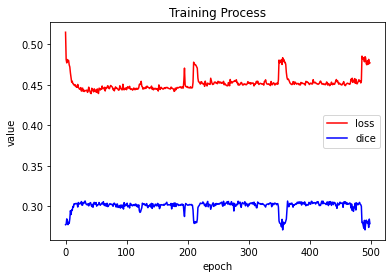

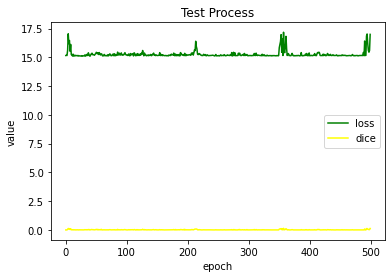

In [10]:
NUM_EPOCHS = 500

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
criterion = nn.BCELoss()

loss_train = []
dice_train = []
loss_test = []
dice_test = []

for epoch in range(NUM_EPOCHS):
  app_loss_train = []
  app_dice_train = []
  app_loss_test = []
  app_dice_test = []

  print('Epoch: {}/{}.'.format(epoch + 1, NUM_EPOCHS))
  print("TRAINING")
  net.train()
  start_epoch = time.time()

  appLoss = 0
  out = display(progress(0, len(x_train)-1), display_id=True)
  start_pat = time.time()
  for i in range(len(x_train)):
    start_batch = time.time()

    output = net(x_train[i].reshape((1, *(x_train[i].shape))))
    output = torch.sigmoid(output)

    loss = criterion(output.view(-1), y_train[i].view(-1))
    app_loss_train.append(loss.cpu().item())
    app_dice_train.append(evalDice(output, y_test).item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    out.update(progress(i, len(x_train)-1))

  print("TESTING")
  out_disp = display(progress(0, len(x_test)-1), display_id=True)
  for i in range(len(x_test)):

    output = net(x_test[i].reshape((1, *(x_train[i].shape))))
    output = (torch.sigmoid(output) > 0.5).float()

    loss = criterion(output[0][0], y_test[i])
    app_loss_test.append(loss.cpu().item())
    app_dice_test.append(evalDice(output, y_test).item())

    out_disp.update(progress(i, len(x_test)-1))

  
  loss_train.append(sum(app_loss_train)/len(app_loss_train))
  dice_train.append(sum(app_dice_train)/len(app_dice_train))
  loss_test.append(sum(app_loss_test)/len(app_loss_test))
  dice_test.append(sum(app_dice_test)/len(app_dice_test))

  print("dice_train: {:.4f}, loss_train: {:.4f}".format(dice_train[-1], loss_train[-1]))
  print("dice_test: {:.4f}, loss_test: {:.4f}".format(dice_test[-1], loss_test[-1]))
  print("time {:.2f}".format(time.time() - start_pat), " s\n")

fig = plt.figure()
plt.title('Training Process')
plt.xlabel('epoch')
plt.ylabel('value')
l1, = plt.plot(loss_train, c='red')
l2, = plt.plot(dice_train, c='blue')
plt.legend(handles=[l1, l2], labels=['loss', 'dice'], loc='best')

fig = plt.figure()
plt.title('Test Process')
plt.xlabel('epoch')
plt.ylabel('value')
l1, = plt.plot(loss_test, c='green')
l2, = plt.plot(dice_test, c='yellow')
plt.legend(handles=[l1, l2], labels=['loss', 'dice'], loc='best')


----- Image: 0 -----


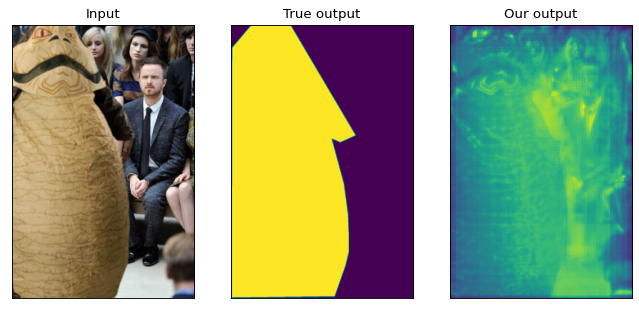


----- Image: 1 -----


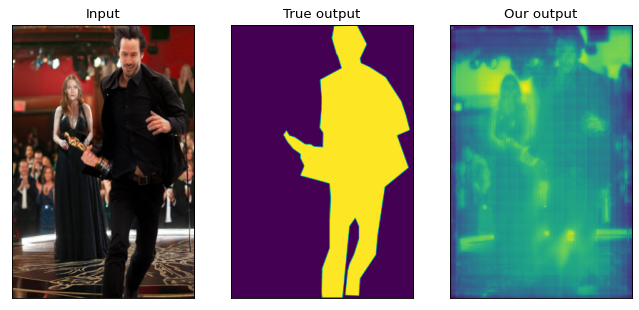


----- Image: 2 -----


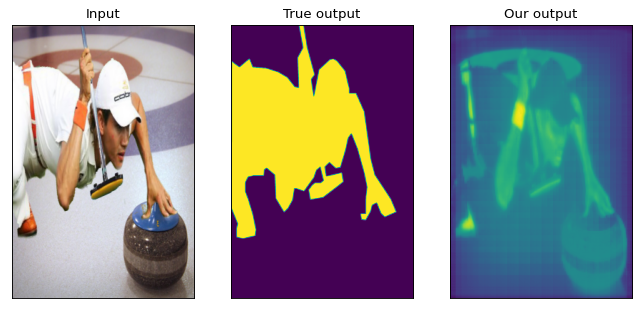


----- Image: 3 -----


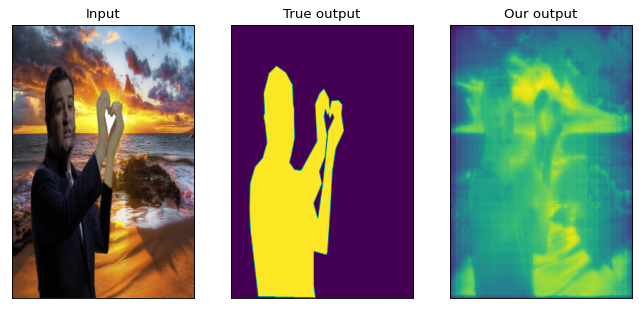


----- Image: 4 -----


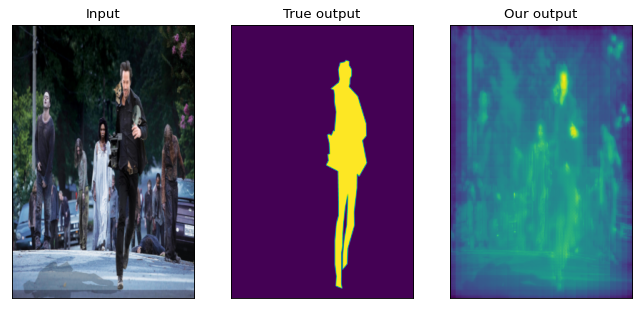

In [11]:
N = 5
pos = []
while len(pos) < N:
  app = np.random.randint(0, len(x_test)-1)
  if not app in pos:
    pos.append(app)

in_m = np.array([x_test[i].cpu().detach().numpy() for i in pos])
in_m = torch.from_numpy(in_m).cuda()
true_out_m = np.array([y_test[i].cpu().detach().numpy() for i in pos])

out_m = net(in_m)

for j in range(len(out_m)):
  print("\n----- Image: %d -----" %j)
  f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), dpi=80)
  plt.setp(ax, xticks=[], yticks=[])
  ax[0].title.set_text("Input")
  ax[0].imshow( np.transpose(in_m[j].cpu().detach().numpy(), axes=[1, 2, 0]) )
  ax[1].title.set_text("True output")
  ax[1].imshow( true_out_m[j] )
  ax[2].title.set_text("Our output")
  ax[2].imshow( out_m[j].cpu().detach().numpy().reshape((384, 256)) )
  plt.show()